# U-net Denoising demo

Notebook containing all work relevant to creating a neural network based denoising pipeline. The notebook contains each of the following steps:

1. Load the data
    1. Load in sources of clean PCGs (Pascal, Physionet 2016)
    2. Load in sources of relevant real-world noises (ESC-50, ARCA-23K, HAN)
2. Normalization steps for the data + build a toolkit for the rest of the notebook
    1. Filtering, zero-mean, match signal lengths, [-1,1] normalization, resample, combine two signals at a SNR, ...
3. Combine the signals and noises to make pairs of noisy-clean PCGs
    1. Do visualizations and other qualitative analyses
4. (Legacy) Create STFT features from those recordings 
5. Create train/val/test splits
6. Model Design
7. Model Training
8. Results Analysis
9. Appendix

## 0. Introduction
This section is for importing libraries and defining paths

### 0.a - Cloud Training
Set the below boolean to true if the code is being run on Rice's cloud clusters

In [391]:
on_cloud = True

### 0.b - Imports

In [392]:
# import libraries
from scipy import signal
from time import time
from copy import deepcopy
from IPython.display import Audio
from sklearn.utils import shuffle
from math import ceil

import random
import librosa
import numpy as np
import psutil
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# reproducibility
seed = 777 # three lucky numbers
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)
# this should take care of reproducibility in sklearn too
# (see https://sklearn-genetic-opt.readthedocs.io/en/stable/tutorials/reproducibility.html)

# if training on cloud
if on_cloud: # !impt: set these. Run nvidia-smi and top first, also check spreadsheet
  device_str = '1'
  threads_str = '2'
  os.environ['CUDA_VISIBLE_DEVICES'] = device_str
  os.environ['OMP_NUM_THREADS'] = threads_str
  os.environ['CUBLAS_WORKSPACE_CONFIG']=":4096:8"

In [393]:
# check reproducibility (run these many times, after running all)
# if randomness is reproducible, the below code should give the same results every time
### Code
#print(get_random_noise_path(),shuffle([1,2,3,4,5], [-1,-2,-3,-4,-5], random_state = seed))
#tr,va,te = torch.utils.data.random_split(dataset,[.7,.15,.15],generator=gen)
#for (inpt,outpt) in make_batch(tr,32):
#  print(inpt,outpt)
#  break
### End Code
# reproducibility is the case for everything it seems (torch, python random, np random, sklearn)

### 0.c - Paths

In [394]:
# for cloud compute vs local running
if torch.cuda.is_available(): # i.e. if not running on my macbook
  # !impt: ^ the assumption is that the non-cloud device doesn't have cuda (this is the case for me)
  prepend = '/mnt/data1/emz1/heart/datasets/'
  split_dir = '/mnt/data1/emz1/heart/splits/'
  model_dir = '/mnt/data1/emz1/heart/models/'

else:
  prepend = '/Users/donu/Desktop/S25/ELEC 594/datasets/'
  split_dir = '/Users/donu/Desktop/S25/ELEC 594/storage/'
  model_dir = '/Users/donu/Desktop/S25/ELEC 594/storage/' # not a typo

prepend

'/mnt/data1/emz1/heart/datasets/'

In [395]:
## Dirs
# the circor digiscope phonocardiogram dataset
pcg_datapath = prepend+'the-circor-digiscope-phonocardiogram-dataset-1.0.3/'
# the bentley dataset is the clean PCG dataset from the U-net paper
pascal_dset_path = prepend+'pascal-dset/'

In [396]:
arcalabels_path = prepend+'ARCA23K_ground_truth/'
# the arcawavs directory contains the real world noise data from the ARCA23K dataset
arcawavs_path = prepend+'ARCA23K_audio/'
# hospital ambient sounds dataset, from the Ali paper
han_raw_path = prepend+'hospital-noise-original/'
han_filtered_path = prepend+'hospital-noise-filtered-resampled/'

In [397]:
# OAHS/physionet '16
physio16_path = prepend+'physio16/'
physio_anno_path = physio16_path +'annotations/Online_Appendix_training_set.csv'

In [398]:
# ESC50 dataset
esc50_path = prepend+'ESC-50/'
esc50_anno_path = esc50_path + 'meta/esc50.csv'

## 1. Loading the data

### 1.a Exploring PCG data

In [399]:
# Exploring the PCG data
pcg_data = pd.read_csv(pcg_datapath+'training_data.csv')

In [400]:
pcg_data.shape

(942, 23)

In [401]:
pcg_data.columns

Index(['Patient ID', 'Recording locations:', 'Age', 'Sex', 'Height', 'Weight',
       'Pregnancy status', 'Murmur', 'Murmur locations',
       'Most audible location', 'Systolic murmur timing',
       'Systolic murmur shape', 'Systolic murmur grading',
       'Systolic murmur pitch', 'Systolic murmur quality',
       'Diastolic murmur timing', 'Diastolic murmur shape',
       'Diastolic murmur grading', 'Diastolic murmur pitch',
       'Diastolic murmur quality', 'Outcome', 'Campaign', 'Additional ID'],
      dtype='object')

In [402]:
pcg_data['Murmur'].value_counts()

Murmur
Absent     695
Present    179
Unknown     68
Name: count, dtype: int64

In [403]:
pcg_data.loc[pcg_data['Murmur'].eq('Absent') | pcg_data['Murmur'].eq('Present')].head()

,Patient ID,Recording locations:,Age,Sex,Height,Weight,Pregnancy status,Murmur,Murmur locations,Most audible location,...,Systolic murmur pitch,Systolic murmur quality,Diastolic murmur timing,Diastolic murmur shape,Diastolic murmur grading,Diastolic murmur pitch,Diastolic murmur quality,Outcome,Campaign,Additional ID
0,2530,AV+PV+TV+MV,Child,Female,98.0,15.9,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
1,9979,AV+PV+TV+MV,Child,Female,103.0,13.1,False,Present,AV+MV+PV+TV,TV,...,High,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
3,13918,AV+PV+TV+MV,Child,Male,98.0,15.9,False,Present,TV,TV,...,Low,Blowing,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
4,14241,AV+PV+TV+MV,Child,Male,87.0,11.2,False,Present,AV+MV+PV+TV,PV,...,Low,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
5,14998,AV+PV+TV+MV,Child,Male,NaN,NaN,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN


### 1.b Loading the PASCAL dataset

In [404]:
pcg_data = pd.read_csv(pascal_dset_path+'set_b.csv')

In [405]:
pcg_data['label'].value_counts()

label
normal        320
murmur         95
extrastole     46
Name: count, dtype: int64

### 1.b.1 - Clean up horrible data formatting

In [406]:
#for i in range(pcg_data.shape[0]):
##  # delete "Btraining"
##  #pcg_data.loc[i,'fname'] = 'setb/'+pcg_data.iloc[i,:]['fname'].split('/')[-1][10:]
#  filename = pcg_data.iloc[i,:]['fname'].split('/')[-1]
#  cut_idx = re.search(r'\d',filename).start()
#  pcg_data.loc[i,'fname'] = pcg_data.loc[i,'fname'].replace('setb','set_b')
#  pcg_data.loc[i,'fname'] = 'set_b/'+filename[cut_idx:]
#  

In [407]:
#pcg_data.to_csv(pascal_dset_path+'set_b.csv',index=False)

In [408]:
pcg_data['sublabel'].value_counts()

sublabel
noisynormal    120
noisymurmur     29
Name: count, dtype: int64

In [409]:
pcg_data = pcg_data.loc[(pcg_data['label'].eq('normal') |
                        pcg_data['label'].eq('murmur')) & 
                        pcg_data['sublabel'].ne('noisynormal') & 
                        pcg_data['sublabel'].ne('noisymurmur')]

In [410]:
pcg_data

,dataset,fname,label,sublabel
46,b,set_b/112_1306243000964_A.wav,murmur,NaN
47,b,set_b/112_1306243000964_B.wav,murmur,NaN
48,b,set_b/112_1306243000964_D.wav,murmur,NaN
49,b,set_b/116_1306258689913_A.wav,murmur,NaN
50,b,set_b/116_1306258689913_C.wav,murmur,NaN
...,...,...,...,...
307,b,set_b/296_1311682952647_A1.wav,normal,NaN
308,b,set_b/296_1311682952647_A2.wav,normal,NaN
309,b,set_b/298_1311685888900_B.wav,normal,NaN
310,b,set_b/299_1311770522820_C.wav,normal,NaN


In [411]:
pcg_data.shape # this does not contain noisy data
# it does not contain murmurs either. this may be hugely importnat
# !IMPT: does not contain unlabelled data (which is like 1/3rd of dataset)

(266, 4)

In [412]:
# write to csv
##pcg_data.to_csv(bentley_dset+'set_b.csv',index=False)

In [413]:
#for fname in os.listdir(bentley_dset+'set_b/'):
#  # renaming
#  cutidx = re.search(r'\d',fname).start()
#  os.rename(bentley_dset+'set_b/'+fname,bentley_dset+'set_b/'+fname[cutidx:])

### 1.b.2 - Find Corresponding wav for each label

In [414]:
times = []
sample_rates = []
pcg_maxes = []
wav_lengths = dict()
for idx, row in pcg_data.iterrows():
  filepath_local = row['fname']
  label = row['label']
  #wavfile.read(pascal_dset_path+filepath_local)[1]
  arr,sr = librosa.load(pascal_dset_path+filepath_local,sr=None)
  length = len(arr)/sr
  
  wav_lengths[filepath_local] = length
  times.append(length) #time
  sample_rates.append(sr)
  pcg_maxes.append(np.max(np.abs(arr)))
print(np.mean(times),np.min(times),np.max(times))
print(np.mean(sample_rates),np.min(sample_rates),np.max(sample_rates))
print(np.mean(pcg_maxes),np.min(pcg_maxes),np.max(pcg_maxes))
times.sort()
PCG_SAMPLE_RATE = np.min(sample_rates) # everything is 22050
print(times[len(times)//5]) # ~20th percentile is 2.06 seconds

CUTOFF_SECONDS = 2
CUTOFF = CUTOFF_SECONDS*PCG_SAMPLE_RATE # 2 seconds
# ok, i think for now we can toss out times below 2 seconds

5.159758458646617 0.76325 24.16
4000.0 4000 4000
0.7936945 0.13998413 1.0
2.063


In [415]:
len(wav_lengths)

266

In [416]:
# checkpoint 1. done so far:
## downlaoded the datasets (synthetic noise, circor, and bentley - the U-net one)
## renamed the horribly named files and .csv column values in the bentley dataset
# able to read the corresponding wavfile for each row in the bentley dataset (i.e. map murmurs to wav!)

In [417]:
#next
## add noise to each, remove noise. see if that's possible
# ok, let's only resample ambient noise.

### 1.c - Loading the ARCA23K real world noises

In [418]:
#os.listdir(arcawavs)
noise_data = pd.read_csv(arcalabels_path+'train.csv')

In [419]:
label_amnts = dict(noise_data['label'].value_counts())

for key in label_amnts.keys():
  #print(key,label_amnts[key])
  pass

In [420]:
# this is now legacy, since all non-relevant labels have been removed
relevant_labels = noise_data.loc[noise_data['label'].eq('Crumpling_and_crinkling') 
                                | noise_data['label'].eq('Child_speech_and_kid_speaking') 
                                | noise_data['label'].eq('Male_speech_and_man_speaking')
                                | noise_data['label'].eq('Female_speech_and_woman_speaking')
                                | noise_data['label'].eq('Cough')
                                | noise_data['label'].eq('Squeak')
                                | noise_data['label'].eq('Walk_and_footsteps')
                                | noise_data['label'].eq('Rattle')
                                | noise_data['label'].eq('Crack')]

important_wavs = set(relevant_labels['fname'].unique())
wav_to_type = dict(zip(relevant_labels['fname'],relevant_labels['label']))

In [421]:
# here is where audio files get selected and loaded in
# # start with the below noise sources # !impt

select_for = set(['Child_speech_and_kid_speaking','Crumpling_and_crinkling','Cough', 'Male_speech_and_man_speaking','Female_speech_and_woman_speaking','Squeak','Crack','Walk_and_footsteps','Rattle'])
list_of_wavs = [] # array of ints, since in the csv file, the wav files are named as numbers
for wavf in os.listdir(arcawavs_path):
  wavname = int(wavf.split('.')[0])
  if wav_to_type[wavname] in select_for:
    list_of_wavs.append(wavname)

In [422]:
len(list_of_wavs) # this isn't large because most of the ARCA23K dataset I deleted (it was huge)

494

In [423]:
## For removing irrelevant audio files. only need to run once

#for wavf in os.listdir(arcawavs):
#  wavname = wavf.split('.')[0]
#  if int(wavname) not in important_wavs:
#    os.remove(arcawavs+wavf)

In [424]:
def rescale_pcg(x):
  """
  normalize an ndarray x to [-1,1] based on largest abs value
  """
  #if np.max(x)>1:
  x = x/np.max(np.abs(x))
  return x

In [425]:
# now, load in the wavs
## resampling them to 4kHz since the clean PCG data is at 4kHz too
for wav_int in list_of_wavs[3:]:
  data, sr = librosa.load(arcawavs_path+str(wav_int)+'.wav',sr=None)
  print(np.max(data),np.min(data),np.mean(data))
  resampled = librosa.resample(data,orig_sr = sr,target_sr = 4000)
  resampled_zeromean = resampled - np.mean(resampled)
  normalized = rescale_pcg(resampled_zeromean)
  normalized = normalized - np.mean(normalized)
  break

0.48880005 -0.42004395 -4.2659335e-06


In [426]:
np.mean(normalized)

-1.7462928e-10

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 3.000e+00, 2.000e+00, 7.000e+00, 4.000e+00, 6.000e+00,
        7.000e+00, 9.000e+00, 1.600e+01, 1.900e+01, 4.000e+01, 5.200e+01,
        6.900e+01, 6.200e+01, 1.250e+02, 1.100e+02, 1.620e+02, 2.090e+02,
        2.710e+02, 5.490e+02, 5.883e+03, 4.810e+02, 2.440e+02, 1.980e+02,
        1.620e+02, 1.340e+02, 1.150e+02, 7.700e+01, 6.000e+01, 3.900e+01,
        3.300e+01, 2.700e+01, 1.900e+01, 1.200e+01, 1.100e+01, 2.000e+00,
        8.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-1.        , -0.96219867, -0.92439735, -0.88659602, -0.8487947 ,
        -0.81099337, -0.77319205, -0.73539072, -0.6975894 , -0.65978813,
        -0.62198681, -0.58418548, -0.54638416, -0.50858283, -0.47078151,
        -0.43298018, -0.39517885, -0.35737753, -0.3195762 , -0.28177488,
        -0.24397357, -0.20617224, -0.16837092, -0.13056961, -0.09276828,
        -0.

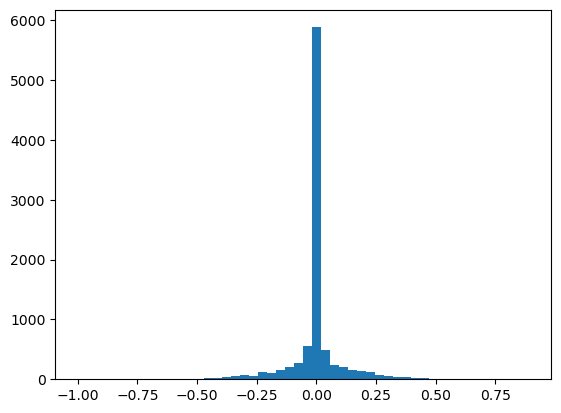

In [427]:
plt.hist(normalized,bins=50)

In [428]:
# i would expect the sound to have 0 mean? this is a Q for JoYo
# next step:
# # filter data? passband the PCG data to 1kHz and resample
# # add the noise to the PCG data (normalize noise first)
# # start to build classifier...
# # can create a stereo track and then combine it to mono?


### 1.d - Exploring ESC-50 dataset

What a blessed dataset. The sounds are so clean and useful, and well annotated.
Most useful classes:
- ['Rain', ' Wind', '  Pouring Water', ' Crying Baby', ' Sneezing', ' Breathing', ' Coughing', ' Footsteps', ' Laughing', ' Creaking', ' Washing Machine', ' Vaccuum', ' Helicopter', ' Siren']

In [429]:
x= 'aefewaa'

In [430]:
x[0].upper()+x[1:].lower()

'Aefewaa'

In [431]:
useful_classes = set(['rain',
 'wind',
 'pouring_water',
 'crying_baby',
 'sneezing',
 'breathing',
 'coughing',
 'footsteps',
 'laughing',
 'door_wood_creaks',
 'washing_machine',
 'vacuum_cleaner',
 'helicopter',
 'siren',
 'snoring'])

In [432]:
esc50_annos_raw = pd.read_csv(esc50_anno_path)

In [433]:
esc50_annos_raw.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [434]:
esc50_annos_raw.columns

Index(['filename', 'fold', 'target', 'category', 'esc10', 'src_file', 'take'], dtype='object')

In [435]:
esc50_annos_raw['category'].unique()

array(['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm',
       'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks',
       'chainsaw', 'airplane', 'mouse_click', 'pouring_water', 'train',
       'sheep', 'water_drops', 'church_bells', 'clock_alarm',
       'keyboard_typing', 'wind', 'footsteps', 'frog', 'cow',
       'brushing_teeth', 'car_horn', 'crackling_fire', 'helicopter',
       'drinking_sipping', 'rain', 'insects', 'laughing', 'hen', 'engine',
       'breathing', 'crying_baby', 'hand_saw', 'coughing',
       'glass_breaking', 'snoring', 'toilet_flush', 'pig',
       'washing_machine', 'clock_tick', 'sneezing', 'rooster',
       'sea_waves', 'siren', 'cat', 'door_wood_creaks', 'crickets'],
      dtype=object)

In [436]:
useful_classes.difference(set(esc50_annos_raw['category']))

set()

In [437]:
esc50_subset_idx = esc50_annos_raw['category'].isin(useful_classes)

In [438]:
np.sum(esc50_subset_idx) # = 40 vids/class * num classes selected for

600

In [439]:
# what you'll be using
esc50_filtered = esc50_annos_raw[esc50_subset_idx]

In [440]:
len(esc50_filtered)

600

In [441]:
esc50_filtered.head()

,filename,fold,target,category,esc10,src_file,take
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
27,1-118559-A-17.wav,1,17,pouring_water,False,118559,A
37,1-137296-A-16.wav,1,16,wind,False,137296,A
39,1-155858-A-25.wav,1,25,footsteps,False,155858,A


In [442]:
esc50_good_idxs = list(esc50_filtered.index) # use for selecting random rows/files

### 1.e - Loading the Physionet 2016 Dataset

In [443]:
physio16_data_raw  = pd.read_csv(physio_anno_path)
num_recordings = physio16_data_raw.shape[0]

#### 1.e.1 - Removing Low Quality Recordings

In [444]:
training_a_sqi = physio16_path+'training-a/REFERENCE-SQI.csv'
training_a_sqi_data = pd.read_csv(training_a_sqi,names=['fname','normal-or-abnormal','SQI'],header=None)

training_b_sqi = physio16_path+'training-b/REFERENCE-SQI.csv'
training_b_sqi_data = pd.read_csv(training_b_sqi,names=['fname','normal-or-abnormal','SQI'])

training_c_sqi = physio16_path+'training-c/REFERENCE-SQI.csv'
training_c_sqi_data = pd.read_csv(training_c_sqi,names=['fname','normal-or-abnormal','SQI'])

training_d_sqi = physio16_path+'training-d/REFERENCE-SQI.csv'
training_d_sqi_data = pd.read_csv(training_d_sqi,names=['fname','normal-or-abnormal','SQI'])

training_e_sqi = physio16_path+'training-e/REFERENCE-SQI.csv'
training_e_sqi_data = pd.read_csv(training_e_sqi,names=['fname','normal-or-abnormal','SQI'])

training_f_sqi = physio16_path+'training-f/REFERENCE-SQI.csv'
training_f_sqi_data = pd.read_csv(training_f_sqi,names=['fname','normal-or-abnormal','SQI'])

In [445]:
training_a_sqi_data.head(3)

,fname,normal-or-abnormal,SQI
0,a0001,1,1
1,a0002,1,1
2,a0003,1,1


In [446]:
a_low_quality = training_a_sqi_data['SQI']<1

b_low_quality = training_b_sqi_data['SQI']<1

c_low_quality = training_c_sqi_data['SQI']<1

d_low_quality = training_d_sqi_data['SQI']<1

e_low_quality = training_e_sqi_data['SQI']<1

f_low_quality = training_f_sqi_data['SQI']<1

print(np.sum(a_low_quality),np.sum(b_low_quality),np.sum(c_low_quality),np.sum(d_low_quality),np.sum(e_low_quality), np.sum(f_low_quality))

17 122 4 3 213 5


In [447]:
low_a = set(training_a_sqi_data.loc[a_low_quality]['fname'])
low_b = set(training_b_sqi_data.loc[b_low_quality]['fname'])
low_c = set(training_c_sqi_data.loc[c_low_quality]['fname'])
low_d = set(training_d_sqi_data.loc[d_low_quality]['fname'])
low_e = set(training_e_sqi_data.loc[e_low_quality]['fname'])
low_f = set(training_f_sqi_data.loc[f_low_quality]['fname'])

In [448]:
# also use manual annotations for set b specifically
respiration_str = "Respiration noise (2=None 3=Insignificant 4=Weak Resp. Noise<2 s 5=Weak Resp. Noise<3 s 6=Weak Resp. Noise <4 s 7=Weak Resp. Noise >4 s 8=Powerfull Resp. Noise<2 s 9=Powerfull Resp. Noise<3 s 10=Powerfull Resp. noise <4 s  11=Powerfull Resp. Noise >4 s 12=Dont know 13=Weak Resp. Noise<1 s 14=Resp. Noise<1 s 15=Powerfull Resp. noise <1 s 16=Weak Rec. Noise<1 s 17=Powerfull Rec. Noise<1 s)"
ambient_str = "Ambient noise (2=None 3=Insignificant 4=Weak Rec. BG<2 s 5=Weak Rec. BG<3 s 6=Weak Rec. BG <4 s 7=Weak Rec. BG >4 s 8=BG. Noise<2 s 9=BG. Noise<3 s 10= BG. noise <4 s 11=BG. Noise >4 s 12=Powerfull BG. Noise<2 s 13=Powerfull BG. Noise<3 s 14=Powerfull BG. noise <4 s  15=Powerfull BG. Noise >4 s 16=Dont know 17=Weak BG. Noise<1 s  18=BG.Noise<1 s 19=Powerfull BG. Noise<1 s)"
noise_str = "Recording noise (2=None 3=Insignificant 4=Beg. Rec. Noise 5=End Rec. Noise 6=Beg-End Reco Noise 7=Weak Rec. Noise<2 s 8=Weak Rec. Noise<3 s 9=Weak Rec. Noise <4 s 10=Weak Rec. Noise >4 s 11=Powerfull Rec. Noise<2 s 12=Powerfull Rec. Noise<3 s 13=Powerfull Rec. noise <4 s 14=Powerfull Rec. Noise >4 s 15=Spikes 16=Dont know 17=Weak Rec. Noise<1 s 18=Powerfull Rec. Noise<1 s)"
abdominal_str = "Abdominal sounds (2=None 3=Insignificant 4=Sto. Noise<2 s 5=Sto. Noise<3 s 6=Sto. Noise <4 s 7=Sto. Noise >4 s 8=Dont know 9=Sto. Noise<1 s)"


# !impt: the cutoff is 5 (at time of writing). this means if a recording has p much any noise, it gets cut
# ... how restrictive do you want to be? 
cutoff_num = 6
noisy_data_b = physio16_data_raw.loc[(physio16_data_raw[respiration_str]>cutoff_num) 
                       | (physio16_data_raw[ambient_str]>cutoff_num)
                        | (physio16_data_raw[noise_str]>cutoff_num)
                        | (physio16_data_raw[abdominal_str]>cutoff_num)] # only tolerate very little noise

In [449]:
noisy_data_b.shape

(298, 26)

In [450]:
# these are the recordings in set b (which fortunately has annotations) which have noise
noisy_b_paths = set(noisy_data_b['Challenge record name'])

In [451]:
low_quality_physio16 = low_a | low_b | low_c | low_d | low_e | low_f | noisy_b_paths

In [452]:
print(f"{len(low_quality_physio16):<3} : Low quality recordings in entire dataset")
print(f"{len(low_quality_physio16.difference(noisy_b_paths)):<3} : Found based on SQI annotations")
print(f"{len(noisy_b_paths):<3} : Found based on set b's noise level annotations")

585 : Low quality recordings in entire dataset
287 : Found based on SQI annotations
298 : Found based on set b's noise level annotations


In [453]:
len(low_quality_physio16) # cut these out

585

In [454]:
rows_to_remove = physio16_data_raw['Challenge record name'].isin(low_quality_physio16)

In [455]:
# this is the final filtered data, for use during the remainder of this notebook
physio16_data = physio16_data_raw[~rows_to_remove]

In [456]:
len(physio16_data) # quite a bit regardless

2653

In [457]:
# relevant columns
normal_str = "Class (-1=normal 1=abnormal)"
murmur_str = "Murmurs (2=None 3=Weak 4=Strong 6=Unclear)"

In [458]:
# explicitly murmurs
murmur_locs = physio16_data_raw[murmur_str]>2 

In [459]:
# number of abnormal heartbeats, filtered vs non-filtered physionet
np.sum(physio16_data[normal_str]>0),np.sum(physio16_data_raw[normal_str]>0)

(538, 665)

In [460]:
physio16_data.head(10)

,Challenge record name,Database,Original record name,Diagnosis,Class (-1=normal 1=abnormal),# Beat (automated algorithm),# Beats requiring hand correction,Gender,Age (year),Height (m),...,# Recording in each subject,Transducer site on body,Recording state,Murmurs (2=None 3=Weak 4=Strong 6=Unclear),"Murmur Location (2=Sys,3=Dia,4=Both)",Arrhythmia (2=None 3=One arrhythmic beat 4=Medium Arrhytmia 5=Severe Arrhytmia 6=Unclear 7=Two arrhythmic beats),Respiration noise (2=None 3=Insignificant 4=Weak Resp. Noise<2 s 5=Weak Resp. Noise<3 s 6=Weak Resp. Noise <4 s 7=Weak Resp. Noise >4 s 8=Powerfull Resp. Noise<2 s 9=Powerfull Resp. Noise<3 s 10=Powerfull Resp. noise <4 s 11=Powerfull Resp. Noise >4 s 12=Dont know 13=Weak Resp. Noise<1 s 14=Resp. Noise<1 s 15=Powerfull Resp. noise <1 s 16=Weak Rec. Noise<1 s 17=Powerfull Rec. Noise<1 s),Ambient noise (2=None 3=Insignificant 4=Weak Rec. BG<2 s 5=Weak Rec. BG<3 s 6=Weak Rec. BG <4 s 7=Weak Rec. BG >4 s 8=BG. Noise<2 s 9=BG. Noise<3 s 10= BG. noise <4 s 11=BG. Noise >4 s 12=Powerfull BG. Noise<2 s 13=Powerfull BG. Noise<3 s 14=Powerfull BG. noise <4 s 15=Powerfull BG. Noise >4 s 16=Dont know 17=Weak BG. Noise<1 s 18=BG.Noise<1 s 19=Powerfull BG. Noise<1 s),Recording noise (2=None 3=Insignificant 4=Beg. Rec. Noise 5=End Rec. Noise 6=Beg-End Reco Noise 7=Weak Rec. Noise<2 s 8=Weak Rec. Noise<3 s 9=Weak Rec. Noise <4 s 10=Weak Rec. Noise >4 s 11=Powerfull Rec. Noise<2 s 12=Powerfull Rec. Noise<3 s 13=Powerfull Rec. noise <4 s 14=Powerfull Rec. Noise >4 s 15=Spikes 16=Dont know 17=Weak Rec. Noise<1 s 18=Powerfull Rec. Noise<1 s),Abdominal sounds (2=None 3=Insignificant 4=Sto. Noise<2 s 5=Sto. Noise<3 s 6=Sto. Noise <4 s 7=Sto. Noise >4 s 8=Dont know 9=Sto. Noise<1 s)
0,a0001,training-a,C45S1,MVP,1,36,0,NaN,NaN,NaN,...,NaN,Left of parasternum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,a0002,training-a,C19S3,MVP,1,27,7,NaN,NaN,NaN,...,NaN,Parasternum when sit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a0003,training-a,C23S0,MVP,1,25,0,NaN,NaN,NaN,...,NaN,Left of parasternum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,a0004,training-a,C35S18,Benign,1,35,0,NaN,NaN,NaN,...,NaN,Left of parasternum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,a0005,training-a,C63S20,Benign,1,52,0,NaN,NaN,NaN,...,NaN,Parasternum when squat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,a0007,training-a,C37S2,Normal,-1,52,27,NaN,NaN,NaN,...,NaN,Parasternum when sit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,a0009,training-a,C63S12,Normal,-1,46,0,NaN,NaN,NaN,...,NaN,Parasternum when squat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,a0010,training-a,C31S4,Benign,1,44,0,NaN,NaN,NaN,...,NaN,Parasternum when squat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,a0011,training-a,C37S0,Normal,-1,34,6,NaN,NaN,NaN,...,NaN,Left of apex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,a0012,training-a,C115S36,Normal,-1,28,4,NaN,NaN,NaN,...,NaN,Parasternum when sit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [461]:
sum(murmur_locs)

78

In [462]:
# !impt: this is really sad. filtering cut out half the murmurs
# of the 78 murmurs in physionet_raw, 32 were too noisy to be used
np.sum(physio16_data[murmur_str]>2)

35

In [463]:
np.sum(physio16_data[murmur_str]>1)

147

In [464]:
# so in total there are 66+35 = 101 murmurs, and ~2.9k total recordings
# this is a dilemma

### 2 - Normalization steps for the data

In [465]:
def lowpass_filter(signal_data, sampling_rate, cutoff_freq, order=4):
    nyquist = 0.5 * sampling_rate  # Nyquist frequency
    normal_cutoff = cutoff_freq / nyquist  # Normalize cutoff frequency
    
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_signal = signal.filtfilt(b, a, signal_data)
    
    return filtered_signal

In [466]:
def plot_fourier_spectrum(audio_signal, sample_rate,step_size=10,title='Fourier Spectrum Magnitude'):
    plt.clf()
    # Compute the FFT
    fft_values = np.fft.fft(audio_signal)
    magnitude = np.abs(fft_values)  # Get magnitude spectrum
    freq = np.fft.fftfreq(len(audio_signal), d=1/sample_rate)  # Frequency axis

    # Keep only the positive frequencies (since this is real valued data)
    half_idx = len(freq) // 2
    freq = freq[:half_idx:step_size] # adding these steps 
    magnitude = magnitude[:half_idx:step_size]

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(freq, magnitude)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.title(title)
    plt.grid()
    plt.show()

In [467]:
# huge Q at this point. What gets resampled to what frequency? 
# # i suppose we are strictly interested in low-ish frequency noise (everything else
# ... would get nuked. )

Original shape: (557918,), Filtered shape: (557918,), Resampled shape: (12652,)


<Figure size 640x480 with 0 Axes>

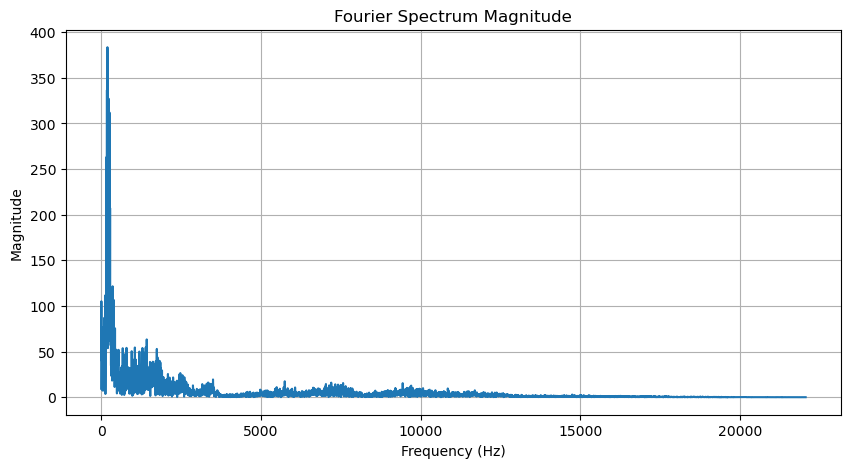

<Figure size 640x480 with 0 Axes>

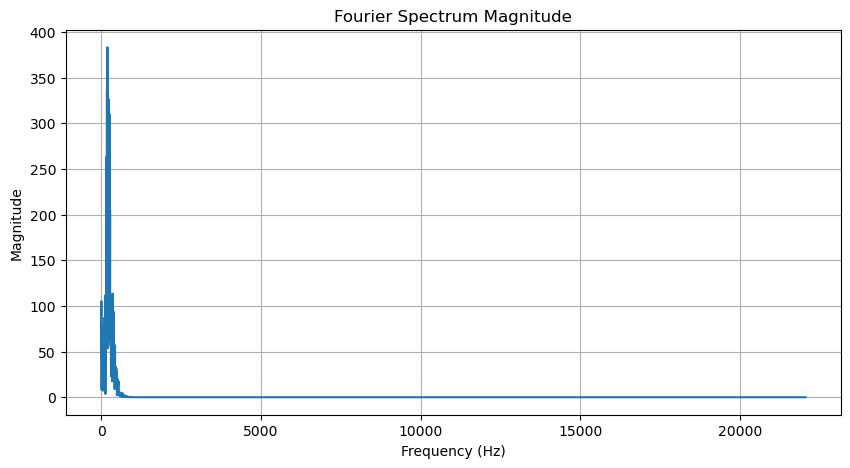

<Figure size 640x480 with 0 Axes>

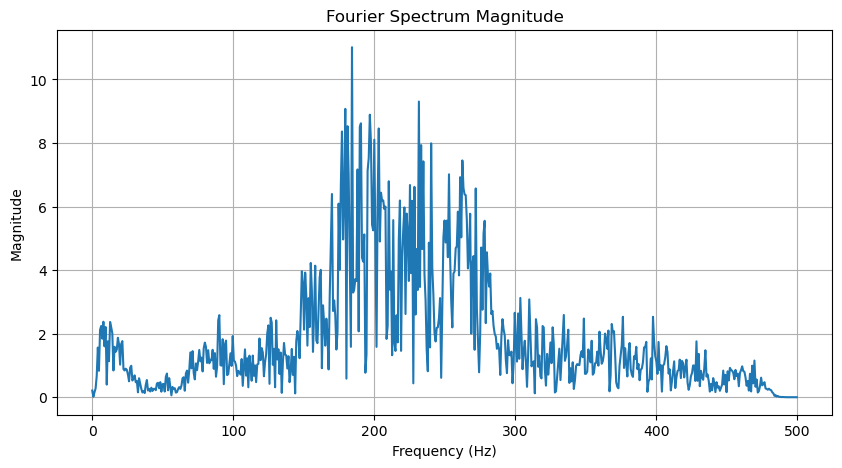

/mnt/data1/emz1/heart/datasets/ARCA23K_audio/407722.wav


In [468]:
# Test 
cutoff_freq = 500
target_freq = cutoff_freq * 2

for wav in list_of_wavs:
    path_to_wav = arcawavs_path + str(wav) + '.wav'
    audiodata, sr = librosa.load(path_to_wav, sr=None)
    # Apply low-pass filter
    audio_data_new = lowpass_filter(audiodata, sr, cutoff_freq)

    # Resample the filtered signal
    new = librosa.resample(audio_data_new, orig_sr=sr, target_sr=target_freq)

    # Debugging info
    print(f"Original shape: {audiodata.shape}, Filtered shape: {audio_data_new.shape}, Resampled shape: {new.shape}")

    # Plot frequency content at each step
    plot_fourier_spectrum(audiodata, sr,step_size=50)  # Original
    plot_fourier_spectrum(audio_data_new, sr,step_size=50)  # After filtering
    plot_fourier_spectrum(new, target_freq,step_size=10)  # After resampling

    print(path_to_wav)
    break  # Stops after first file (as intended)


In [469]:
def load_from_filepath(filepath):
    """
    Load an audio file from a given file path and return the audio data and sample rate.
    """
    audio_data, sample_rate = librosa.load(filepath,sr=None)
    return audio_data, sample_rate

In [470]:
def downsample(audiodata, sr, target_freq):
  """
  Given a filepath for a wav, downsamples the audio to a target frequency
  (applies an LPF beforehand accordingly)
  """
  if sr<target_freq:
    raise Exception("Sample rate too low")
  if sr==target_freq: # this is the case for physionet
    # it was mentioned in pnet16 paper an anti-aliasing filter was already applied. just return audiodata
    return audiodata
  audio_data_new = lowpass_filter(audiodata, sr, target_freq//2)
  new = librosa.resample(audio_data_new, orig_sr=sr, target_sr=target_freq)
  return new

In [471]:
%%script false --no-raise-error # this cell has served its use
for wav in list_of_wavs:
  path_to_wav = arcawavs_path + str(wav) + '.wav'
  arca_data, arca_sr = load_from_filepath(path_to_wav)
  downsample(arca_data, arca_sr, 2000)

#### Comments
- I think a good enough idea is to LPF everything at 1kHz, then resample to 2kHz 

### 2.b - Examine Spectra of PCG Recordings

In [472]:
%%script false --no-raise-error 
# cell disabled (it served its purpose)
dsample_freq = 2000
fnames = pcg_data['fname'].tolist()
print(len(fnames))
for f_name in fnames[::-53]: # anything weird about the spectra?
  path_to_wav = pascal_dset_path + f_name
  pcg_recording, pcg_sr = load_from_filepath(path_to_wav)
  print(pcg_sr)
  #d_sampled = downsample(pcg_recording, pcg_sr, dsample_freq)
  plot_fourier_spectrum(pcg_recording,pcg_sr,step_size=50)
  #plot_fourier_spectrum(d_sampled, dsample_freq,step_size=50)  # Original

set_b/254_1309350589009_C.wav murmur
set_b/254_1309350589009_D.wav murmur
set_b/276_1311162716489_C.wav murmur


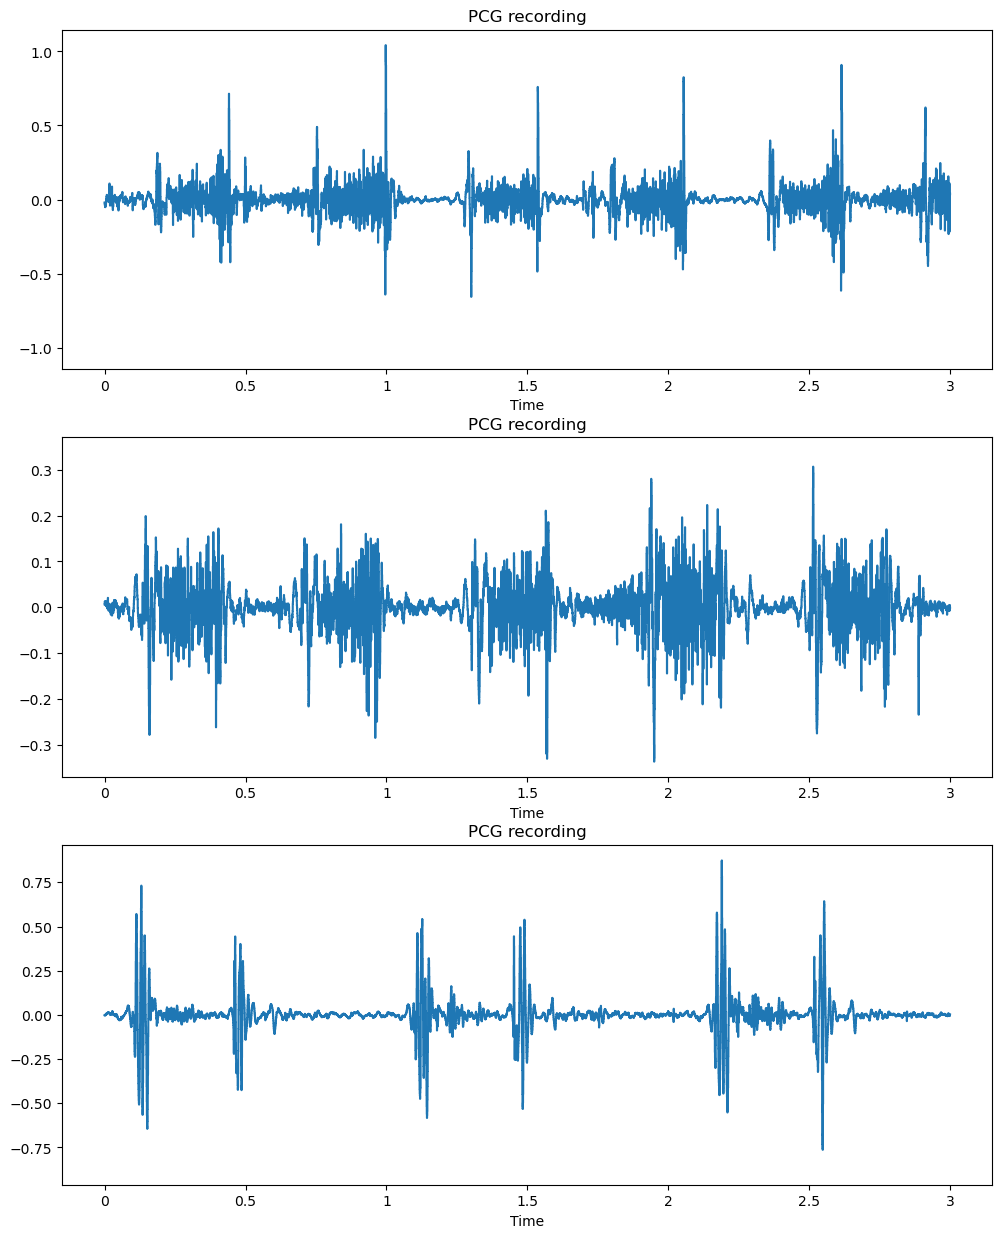

In [473]:
# examining the recordings in time as well

target_freq = 2000
num_to_show=3
startidx = 55

fig, ax = plt.subplots(nrows=num_to_show, figsize=(12, 5*num_to_show))
# want to show the same length for all of them actually. 3 seconds. 
good_idx = 0
for rowidx,row in pcg_data.iloc[startidx:,:].reset_index().iterrows():
  if num_to_show<=good_idx: 
    break
  
  # recording name and type
  fname = row['fname']
  fpath = pascal_dset_path+fname
  
  # load the data
  data, sr = load_from_filepath(fpath)
  length_of_rec = len(data)/sr
  # want to plot the same length for all recordings
  if length_of_rec<=3: 
    continue
  # good to plot
  print(fname, row['label'])
  #print(max(data))
  data = downsample(data,sr,target_freq) # downsampled data
  #print(max(data))
  ax[good_idx].set(title='PCG recording')
  #ax[1].set(title='PCG+Noise')
  librosa.display.waveshow(data[:target_freq*3],sr=target_freq,ax=ax[good_idx]) # original data
  good_idx+=1
  
# data either looks ok ish or horrible

## 3 - Add noise to the recordings

In [474]:
def get_random_noise_path():
  random_wav = random.choice(list_of_wavs)
  #label = noise_data[noise_data['fname'] == random_wav]['label'].values[0]
  #print(f'ARCA23K file: {random_wav}. Noise Type: {label}') # obnoxious
  # !impt: there seems to be an enormous rate of mislabelling. terrible dset...
  return arcawavs_path + str(random_wav) + '.wav'

In [475]:
def get_n_random_noise_paths_arca(n):
  return [arcawavs_path + str(x) + '.wav' for x in random.sample(list_of_wavs, n)]

In [476]:
def get_n_random_noise_paths_han(n):
  return [han_raw_path + x for x in random.sample(os.listdir(han_raw_path), n)]

In [477]:
def get_n_random_noise_paths_esc(n):
  random_rows = random.sample(esc50_good_idxs,n)
  filenames = esc50_filtered['filename'][random_rows]
  #print(esc50_filtered['category'][random_rows])
  return [esc50_path+'audio/'+filename for filename in filenames]

In [478]:
get_n_random_noise_paths_esc(3)

['/mnt/data1/emz1/heart/datasets/ESC-50/audio/2-91912-A-33.wav',
 '/mnt/data1/emz1/heart/datasets/ESC-50/audio/4-198025-A-23.wav',
 '/mnt/data1/emz1/heart/datasets/ESC-50/audio/4-144083-A-16.wav']

In [479]:
len(data)

12434

In [480]:
path_to_plot = get_n_random_noise_paths_esc(1)[0]
data, sr = load_from_filepath(path_to_plot)
Audio(data=data,rate=sr)

In [481]:
#%script false --no-raise-error
# !impt: IPython playback doesn't work for SR below 3k. 
# # this is sad because I'd like to listen to my downsampled files
# # however qualitatively if i downsample just above 3k and listen, things sound nice
# # from this i conclude that my downsample function is working as intended
dataa = downsample(data, sr, 4050)
downsampled = np.asarray(dataa, dtype=np.float32)

# Correct normalization logic
ds_max = np.max(np.abs(downsampled))
#if ds_max> 1:
#downsampled /= ds_max

# Then play it
Audio(data=downsampled, rate=4050)

44100
0.57476807 -0.67822266
post 0.5514851808547974
44100
0.07577515 -0.10015869
post 0.06987811625003815


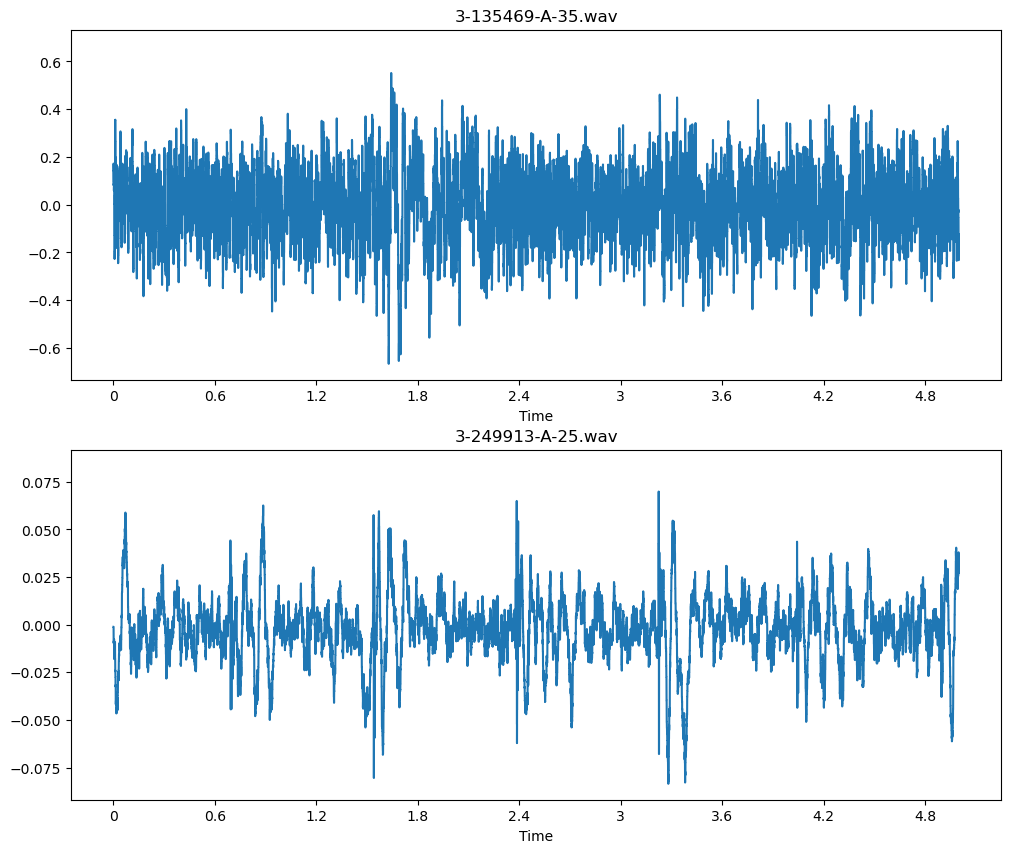

In [482]:
# plot esc sounds
plot_n = 2
fig, ax = plt.subplots(nrows=plot_n, figsize=(12, 5*plot_n))
for plotidx,path in enumerate(get_n_random_noise_paths_esc(plot_n)):
  data, sr = load_from_filepath(path)
  print(sr)
  print(np.max(data),np.min(data))
  data = downsample(data,sr,target_freq)
  librosa.display.waveshow(data[:target_freq*5],sr=target_freq,ax=ax[plotidx]) # original data
  print(f"post {np.max(data)}")
  
  ax[plotidx].set(title=f'{path.split("/")[-1]}')
  #ax[1].set(title='PCG+Noise')

In [483]:
get_n_random_noise_paths_arca(5)

['/mnt/data1/emz1/heart/datasets/ARCA23K_audio/390691.wav',
 '/mnt/data1/emz1/heart/datasets/ARCA23K_audio/458372.wav',
 '/mnt/data1/emz1/heart/datasets/ARCA23K_audio/445921.wav',
 '/mnt/data1/emz1/heart/datasets/ARCA23K_audio/69300.wav',
 '/mnt/data1/emz1/heart/datasets/ARCA23K_audio/376293.wav']

0.77124023 -1.0
post 0.6944400072097778
0.82110596 -1.0
post 0.3725447356700897


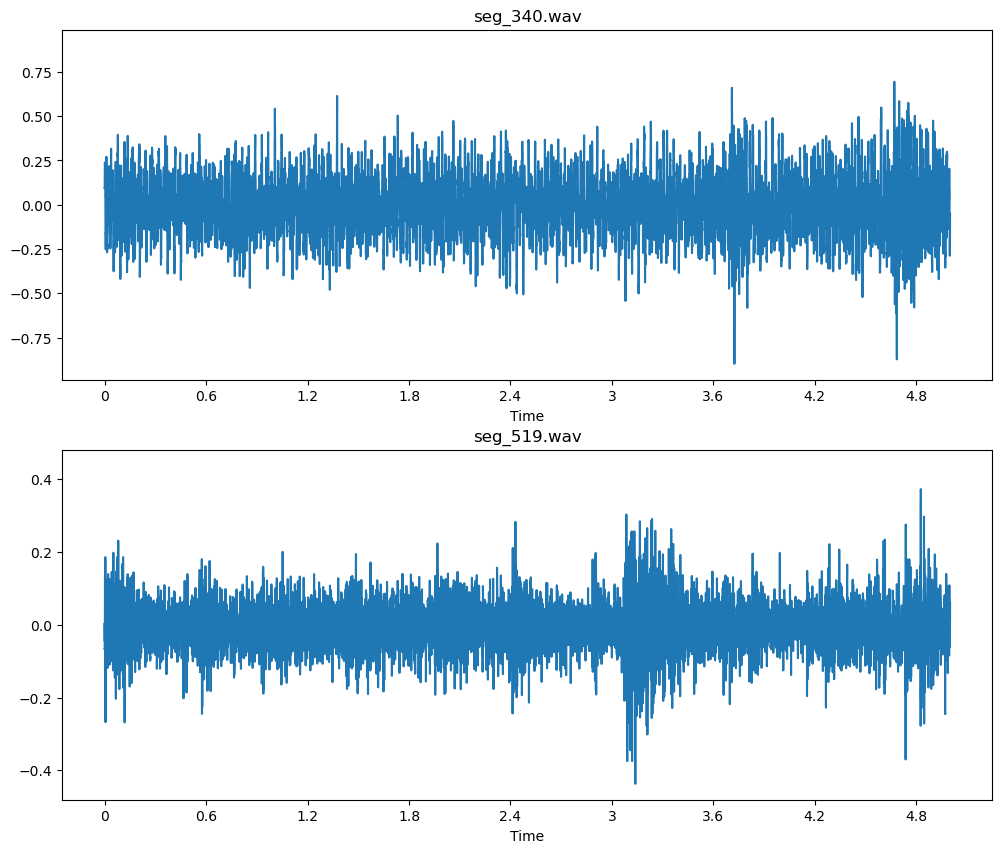

In [484]:
plot_n = 2
fig, ax = plt.subplots(nrows=plot_n, figsize=(12, 5*plot_n))
for plotidx,path in enumerate(get_n_random_noise_paths_han(plot_n)):
  data, sr = load_from_filepath(path)
  print(np.max(data),np.min(data))
  data = downsample(data,sr,target_freq)
  librosa.display.waveshow(data[:target_freq*5],sr=target_freq,ax=ax[plotidx]) # original data
  print(f"post {np.max(data)}")
  ax[plotidx].set(title=f'{path.split("/")[-1]}')
  #ax[1].set(title='PCG+Noise')

0.75756836 -0.9885254
post 0.630923867225647
0.9999695 -1.0
post 0.27157101035118103


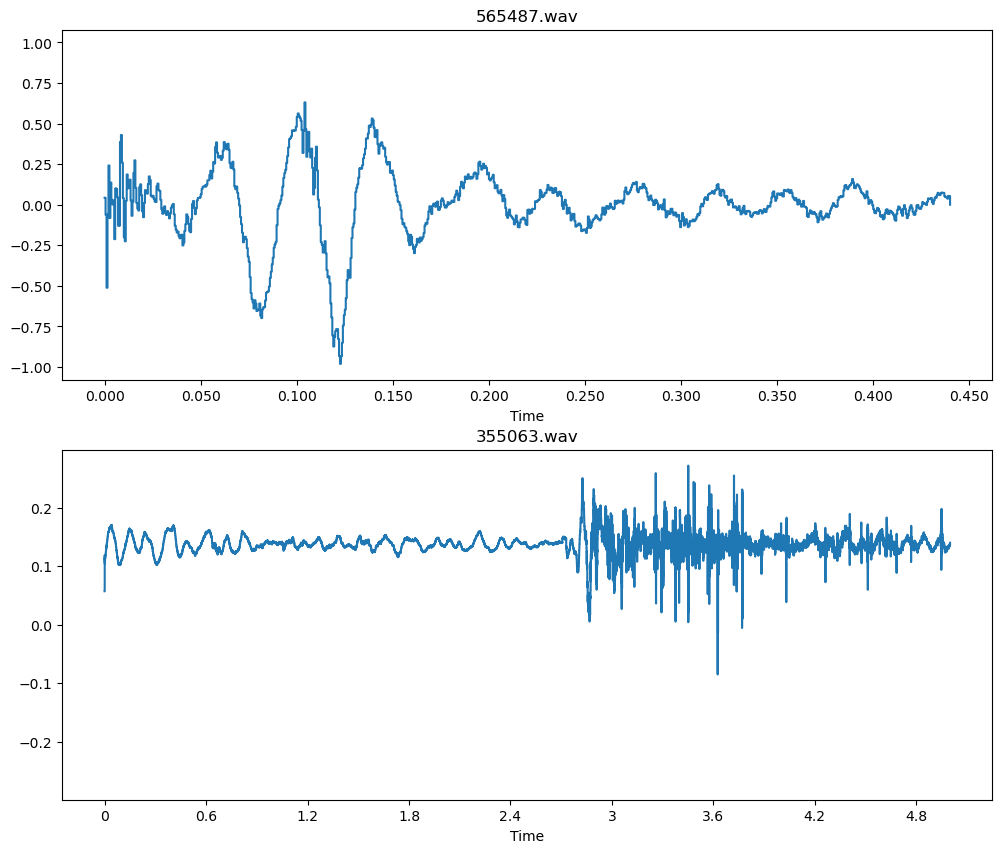

In [485]:
plot_n = 2
fig, ax = plt.subplots(nrows=plot_n, figsize=(12, 5*plot_n))
for plotidx,path in enumerate(get_n_random_noise_paths_arca(plot_n)):
  data, sr = load_from_filepath(path)
  print(np.max(data),np.min(data))
  data = downsample(data,sr,target_freq)
  librosa.display.waveshow(data[:target_freq*5],sr=target_freq,ax=ax[plotidx]) # original data
  print(f"post {np.max(data)}")
  ax[plotidx].set(title=f'{path.split("/")[-1]}')
  #ax[1].set(title='PCG+Noise')

In [486]:
get_n_random_noise_paths_han(5)

['/mnt/data1/emz1/heart/datasets/hospital-noise-original/seg_188.wav',
 '/mnt/data1/emz1/heart/datasets/hospital-noise-original/seg_82.wav',
 '/mnt/data1/emz1/heart/datasets/hospital-noise-original/seg_217.wav',
 '/mnt/data1/emz1/heart/datasets/hospital-noise-original/seg_137.wav',
 '/mnt/data1/emz1/heart/datasets/hospital-noise-original/seg_189.wav']

In [487]:
noise_data

,fname,label,mid
0,507,Acoustic_guitar,/m/042v_gx
1,251090,Acoustic_guitar,/m/042v_gx
2,161470,Acoustic_guitar,/m/042v_gx
3,18489,Acoustic_guitar,/m/042v_gx
4,251185,Acoustic_guitar,/m/042v_gx
...,...,...,...
17974,463104,Zipper_(clothing),/m/01s0vc
17975,575516,Zipper_(clothing),/m/01s0vc
17976,403656,Zipper_(clothing),/m/01s0vc
17977,562333,Zipper_(clothing),/m/01s0vc


In [488]:
get_random_noise_path() # this does get a random noise

'/mnt/data1/emz1/heart/datasets/ARCA23K_audio/328783.wav'

In [489]:
def match_signal_and_noise_lengths(signal, noise):
  """
  Given a signal and noise, makes the noise the same length as signal
  through duplicating, then truncating
  - truncating the noise
  """
  signal_len = len(signal)
  noise_len = len(noise)
  
  if signal_len > noise_len:
    # Repeat the noise to match the signal length
    noise = np.tile(noise, signal_len // noise_len + 1)
  noise = noise[:signal_len]
  return noise

In [490]:
match_signal_and_noise_lengths(np.array([1,2,3,4,5,6,7]),np.array([1,2,3]))

array([1, 2, 3, 1, 2, 3, 1])

In [491]:
match_signal_and_noise_lengths(np.array([1,2]),np.array([3,2,1]))

array([3, 2])

In [492]:
def avg_power(recording):
  """Calculates average power of a recording
  
  Input: A signal, e.g. PCG recording (np.array or similar)
  Output: power (float)
  """
  return np.mean(recording**2)

In [493]:
def snr_calc(clean, noisy):
  """
  Calculate the SNR of a signal given its clean reference.
  """
  clean_power = avg_power(clean)
  noise_signal = noisy - clean
  noise_power = avg_power(noise_signal)
  return 10*np.log10(clean_power/noise_power)

In [494]:
def rmse(clean,noisy):
  """
  Calculate the root mean squared error between two signals
  """
  return avg_power(clean-noisy)**0.5

In [495]:
def create_composite_at_snr(signal,noise,snr_db):
  """
  Function to combine two audio arrays, one signal one noise, at a given SNR
  
  SNR is in dB
  """
  signal_power = avg_power(signal)
  noise_power = avg_power(noise)
  if np.round(noise_power,7) == 0:
    #print('Noise power is 0. Returning signal only') !impt
    return signal
  ratio = np.sqrt((signal_power / noise_power) / (10 ** (snr_db / 10)))
  noise *= ratio
  return signal + noise

In [496]:
def create_composite(pcg_raw, pcg_sr, noise_raw, noise_sr, target_freq, snr):
  """
  A top-level function that combines the above functions to create a composite sound.
  
  Given a PCG filepath and a noise filepath, creates a composite sound by adding the two together.
  Both files are downsampled to the target frequency.
  
  
  Inputs:
  - pcg_filepath
  - noise_filepath
  - target_freq: the frequency to downsample the pcg data and noise data to
  - snr: desired SNR in dB of the combined sounds
  
  Returns the (downsampled) ground truth PCG data and the composite sound, an
  the maximum value of the composite sound before rescaling.
  """
  pcg = downsample(pcg_raw, pcg_sr, target_freq) # downsample the PCG data
  pcg = rescale_pcg(pcg) # !impt: renormalize pcg data. resume work here
  noise = downsample(noise_raw, noise_sr, target_freq)
  noise = match_signal_and_noise_lengths(pcg, noise) # they are now the same size
  composite = create_composite_at_snr(pcg, noise, snr) # combine the two
  mval_composite = np.max(np.abs(composite))
  composite = rescale_pcg(composite) # normalize. I think this is good... 
  
  return pcg, composite, mval_composite # composite. Return mval for accurate SNR calculation way later

<Figure size 640x480 with 0 Axes>

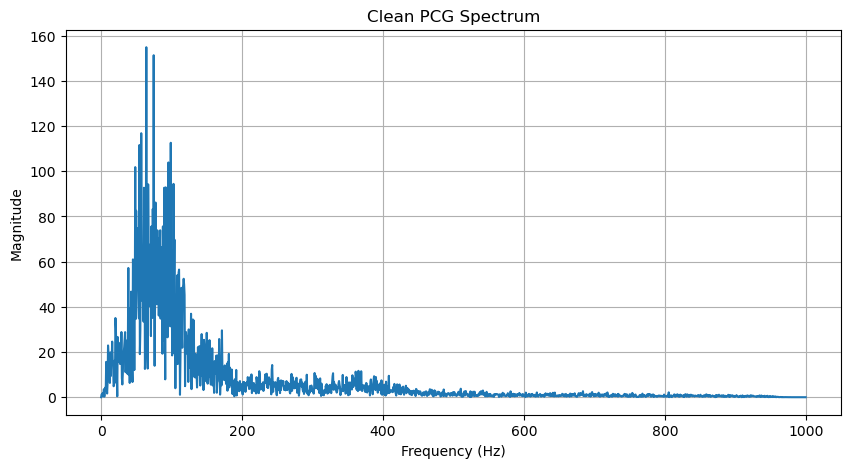

<Figure size 640x480 with 0 Axes>

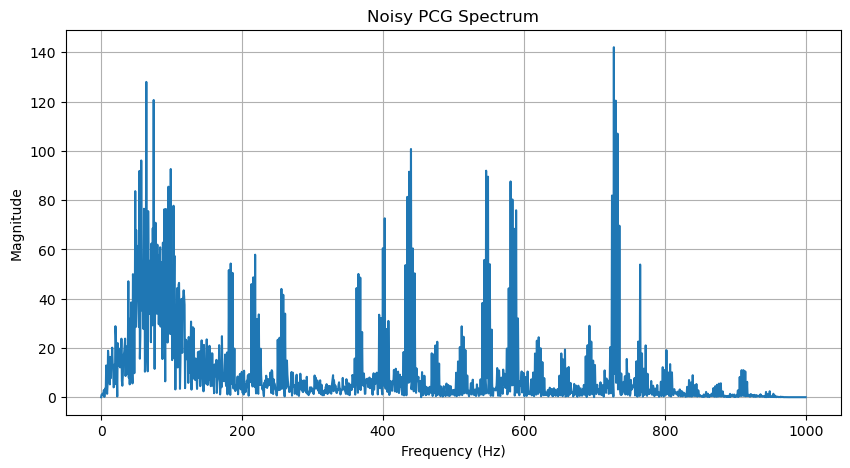

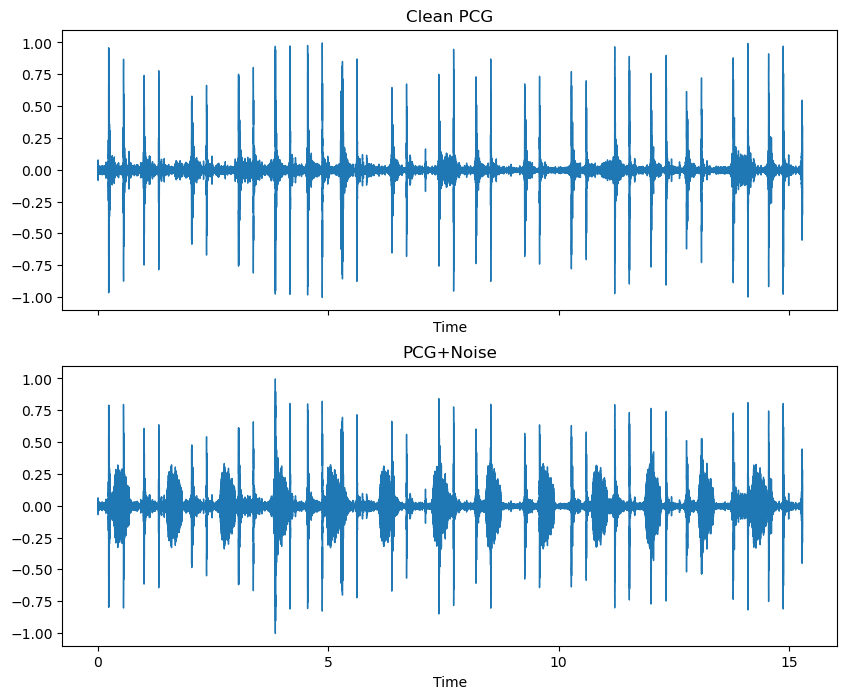

In [497]:
# proof of concept: see the spectrum of a clean PCG and a composite sound
target_freq = 2000 # downsample to this
snr_db = 3
for clean_pcg in pcg_data['fname'][2:]:
  if not clean_pcg.endswith('.wav'): # avoid .DS_Store among other things
    continue
  pcg_filepath = pascal_dset_path + clean_pcg
  random_noise = get_random_noise_path()
  
  pcg_raw, pcg_sr = load_from_filepath(pcg_filepath)
  #print(np.min(pcg_raw),np.max(pcg_raw)) # for seeing range
  noise_raw, noise_sr = load_from_filepath(random_noise)
  
  clean, composite, mval = create_composite(pcg_raw, pcg_sr, noise_raw, noise_sr, target_freq,snr_db)
  # here is where el magico happenso. 
  # look at all the functions you wrote and find a use for them 
  # # e.g. downsample_from_filepath
  
  clean -= np.mean(clean) # DC components shouldn't be useful...?
  #print(np.min(clean),np.max(clean)) # for seeing range
  composite -= np.mean(composite)
  # now visualize. in frequency:
  plot_fourier_spectrum(clean,target_freq,step_size=10,title = 'Clean PCG Spectrum')
  plot_fourier_spectrum(composite,target_freq,step_size=10,title = 'Noisy PCG Spectrum')
  # in time
  fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 8))
  ax[0].set(title='Clean PCG')
  ax[1].set(title='PCG+Noise')
  librosa.display.waveshow(clean,sr=target_freq,ax=ax[0])
  librosa.display.waveshow(composite,sr=target_freq,ax=ax[1])
  break

In [498]:
#!impt: so, there is often a huge DC component introduced. i am not sure why this is.
# perhaps the NN will learn to discard it, which would be fine. 
# but, it's also a pretty simple thing to discard

## 4 - Making the STFT features

In [499]:
from scipy.signal import ShortTimeFFT

In [500]:
#ShortTimeFFT()
nperseg = 1024
hann = signal.windows.hann(nperseg)

In [501]:
SFT = ShortTimeFFT(hann, hop=nperseg//4, fs = target_freq)

### 4.a - Creating Inputs and outputs for the model

In [502]:
unique_shapes, unique_shapes_2 = set(), set()

input_stft_data = []
output_stft_data = []

for pcg_local_path in pcg_data['fname']:
  if not pcg_local_path.endswith('.wav'): # avoid .DS_Store among other things
    continue
  if not wav_lengths[pcg_local_path] > CUTOFF_SECONDS:
    continue
  # here we have a problem with the function about "create composite from filepaths"
  pcg_filepath = pascal_dset_path + clean_pcg
  random_noise = get_random_noise_path()
  
  pcg_raw, pcg_sr = load_from_filepath(pcg_filepath)
  noise_raw, noise_sr = load_from_filepath(random_noise)
  pcg_raw = pcg_raw[:CUTOFF] # truncate the PCG data, to 2 seconds. 

  clean, composite, mval = create_composite(pcg_raw, pcg_sr, noise_raw, noise_sr, target_freq,snr_db)
  clean -= np.mean(clean)
  composite -= np.mean(composite)

  # now, stft:
  stft_clean = SFT.stft(clean)
  unique_shapes.add(tuple(stft_clean.shape)) # everything is 513x18
  stft_noisy = SFT.stft(composite)
  unique_shapes_2.add(tuple(stft_noisy.shape)) # everything is 513x18
  
  input_stft_data.append(stft_noisy[2])
  output_stft_data.append(stft_clean[2])
#print(unique_shapes,unique_shapes_2)
# !impt: 151 sounds in total, of which 126 are unique. the most prevalent sound occurs 4 times.abs
# # (there is a bit of re-use overall)

<Figure size 640x480 with 0 Axes>

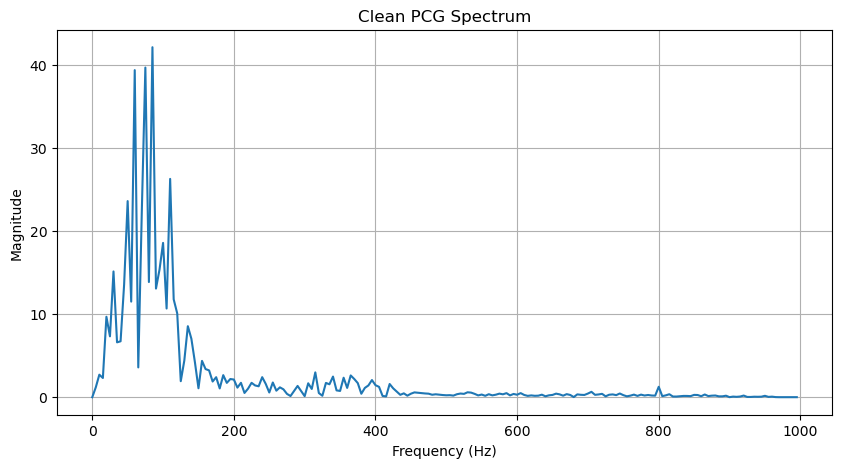

<Figure size 640x480 with 0 Axes>

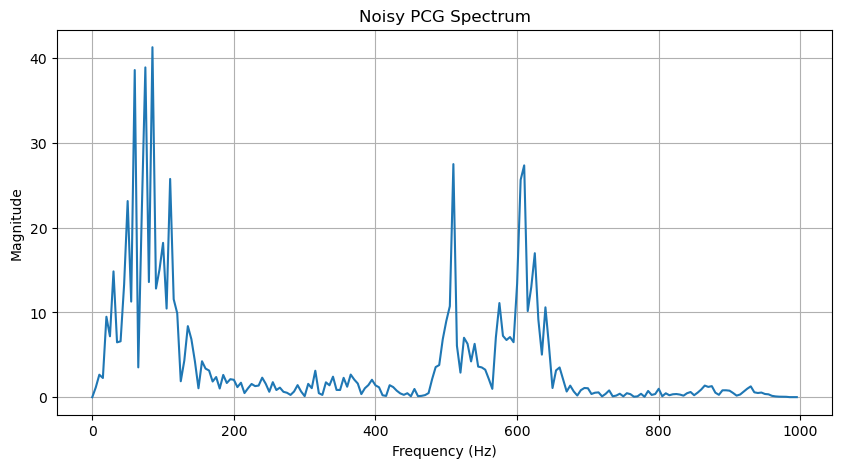

In [503]:
plot_fourier_spectrum(clean,target_freq,step_size=10,title = 'Clean PCG Spectrum')
plot_fourier_spectrum(composite,target_freq,step_size=10,title = 'Noisy PCG Spectrum')

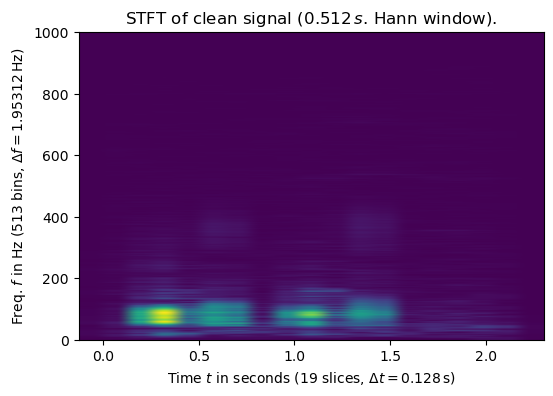

In [504]:
fig1, ax1 = plt.subplots(figsize=(6., 4.))
N = len(clean)
t_lo, t_hi = SFT.extent(N)[:2]
ax1.set_title(rf"STFT of clean signal ({SFT.m_num*SFT.T:g}$\,s$. Hann window).")
ax1.set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))

im1 = ax1.imshow(abs(stft_clean), origin='lower', aspect='auto',
                 extent=SFT.extent(N), cmap='viridis')

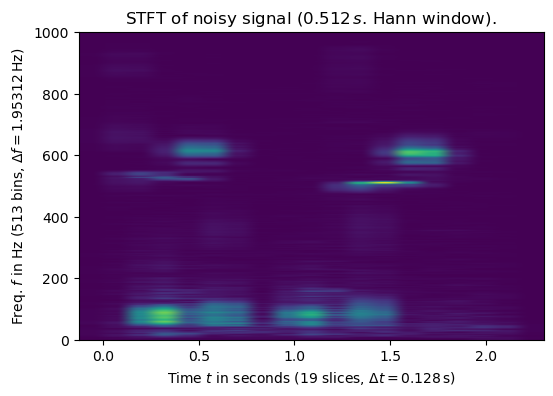

In [505]:
fig2, ax2 = plt.subplots(figsize=(6., 4.))
N = len(clean)
t_lo, t_hi = SFT.extent(N)[:2]
ax2.set_title(rf"STFT of noisy signal ({SFT.m_num*SFT.T:g}$\,s$. Hann window).")
ax2.set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))

im2 = ax2.imshow(abs(stft_noisy), origin='lower', aspect='auto',
                 extent=SFT.extent(N), cmap='viridis')

In [506]:
#stft_noisy # this is complex. should the real and imag parts be split?

In [507]:
# !impt: do i have enough data? So far, 200-some noisy samples...
# ways to get more data:
# # add multiple noise copies to each PCG sample

## 5 - Making Training and Test Data

### 5.a - Functions to combine clean PCGs with noises

In [508]:
def murmur_presence_pascal(fname):
  murmur_here = pcg_data['label'][pcg_data['fname']==fname]
  return murmur_here.item() == 'murmur'

In [509]:
def murmur_presence_physio16(fname):
  # presupposes that fname exists
  fname_reduced = fname[:-4]
  murmur_here = physio16_data[murmur_str][physio16_data['Challenge record name']==fname_reduced]
  return murmur_here.item() > 2 # i.e. if murmur is at least weak

In [510]:
np.sum([murmur_presence_physio16(crn+'.wav') for crn in physio16_data['Challenge record name']]) # num of included murmurs

35

In [511]:
idx_to_set = ['training','val','test']

def create_segments(dset_name,pcg_path,num_noises,snr_db,segment_length,pairs,idx):
  """ 
  Given a pcg path and a set of noises, add the noises to copies of the PCG
  
  Inputs:
  - dset_name: What dataset the PCG came from (valid inputs: pascal, physionet16, physionet22)
  - pcg_path: The file path to the PCG 
    #!impt: pcg_path should reflect the local path of the signal within its dataset
  - num_noises: Array containing integers being the # of noises to take from each noise dataset
  - snr_db: Array of SNR values to combine the PCG and the noises at
  - segment_length: Desired length of each segment (in terms of array length) 
  - pairs: An array to store metadata
  - idx: integer, 0,1,2, representing split (0=training, 1=val, 2=test)
  Returns three arrays: clean PCG segments, noisy PCG segments, and metadata about segments
  """
  from_pascal,from_physio16 = 0,0 #keep track of where the PCGs came from
  
  if dset_name =='pascal': 
    signal_filepath = pascal_dset_path + pcg_path
    murmur_present = murmur_presence_pascal(pcg_path) 
    from_pascal = 1
    
  elif dset_name =='physio16': # here pcg_path is expected to be dataset+fname (e.g. training-a/a0001.wav)
    signal_filepath = physio16_path + pcg_path 
    fname = pcg_path.split('/')[-1]
    murmur_present = murmur_presence_physio16(fname)
    from_physio16 = 1
    
  else:
    print("Dataset doesn't exist.")
    return 0
  
  clean_pcgs = []
  noisy_pcgs = []
  metadata = []
  
  # where the noises get added. Keep doing += for each new dataset
  noises_to_look_at = get_n_random_noise_paths_han(num_noises[0])
  noises_to_look_at += get_n_random_noise_paths_arca(num_noises[1])
  noises_to_look_at += get_n_random_noise_paths_esc(num_noises[2])
  
  signal_raw, signal_sr = load_from_filepath(signal_filepath)
  for snr in snr_db:
    # get a random noises from the han dataset
    for noise_path in noises_to_look_at: 
      # load noise and create composite
      noise_raw, noise_sr = load_from_filepath(noise_path)
      clean, composite, mval = create_composite(signal_raw, signal_sr, noise_raw, noise_sr, target_freq, snr)
      
      local_noise_path = noise_path.split('datasets/')[-1] # !impt: here we assume that we keep the datasets/ dir
      pairs[idx].append([idx_to_set[idx], dset_name, clean_pcg, local_noise_path,snr,murmur_present])
      # cut each pair of recordings into fixed length subsections
      for i in range(0,len(clean)//segment_length):
        # segmentation
        clean_subsection = clean[i*segment_length:(i+1)*segment_length]
        composite_subsection = composite[i*segment_length:(i+1)*segment_length]
        # append
        clean_pcgs.append(clean_subsection)
        noisy_pcgs.append(composite_subsection)
        # metadata
        metadata.append(np.array([mval,snr,murmur_present,from_pascal,from_physio16])) # !impt: this is metadata structure

  return clean_pcgs, noisy_pcgs, metadata

#### 5.b - Prep work for generating synthetically noisy PCGs

In [512]:
gen = torch.Generator().manual_seed(seed) # this is new!

In [513]:
# get each pcg path from each dataset. tuple of form (dsetname, path)
pcgpaths_pascal = [('pascal',x) for x in pcg_data['fname']]

In [514]:
# for physionet
pcgpaths_physio16 = []
for index, row in physio16_data.iterrows():
  pcgpaths_physio16.append(('physio16',row['Database']+'/'+row['Challenge record name']+'.wav'))

In [515]:
# combine both
pcg_paths = pcgpaths_pascal + pcgpaths_physio16

In [516]:
# do this to ensure that no PCG is in more than 1 of the train/test/val datasets
fnames_np_pascal = pcg_data['fname'].to_numpy()
training_list,val_list,test_list = torch.utils.data.random_split(pcg_paths,[0.7,0.15,0.15],generator=gen)
inpt_data = [[],[],[]]
outpt_data = [[],[],[]]
metadata_data = [[],[],[]]

In [517]:
total_pcg_count = sum([len(training_list),len(val_list),len(test_list)])
total_pcg_count

2919

In [518]:
pairs = [[],[],[]] # training, val, test 
# !impt: format = (which_dset, pcg_path, noise_path, snr)

In [519]:
# !impt: This cell shapes everything about how data is created 
target_freq = 2000 # downsample to this
snr_db = [-3,0,3,6]
seconds_per_segment = 0.8
segment_length = int(target_freq*seconds_per_segment)
# determines dataset size
han_inputs, arca_inputs, esc_inputs = 3, 2, 3
num_noises = [han_inputs,arca_inputs,esc_inputs]

### 5.c - Allocating memory

#### 5.c.1 - Pre-compute dataset sizes

In [520]:
# it is very helpful to know in advance how large your datasets will be
# this is useful for memmap
def len_of_split(list_of_pcgs):
  """
  Returns the amount of PCG segments that will eventually come from a list of PCGs
  """
  # total number of segments
  total = 0
  
  for dataset_name, pcg_path in list_of_pcgs:
    # list_of_pcgs is of form (dset, path). e.g. ('physio16','training-a/a0001.wav')
    if dataset_name =='pascal': 
      signal_filepath = pascal_dset_path + pcg_path
    if dataset_name =='physio16': # here pcg_path is expected to be dataset+fname (e.g. training-a/a0001.wav)
      signal_filepath = physio16_path + pcg_path 
    
    # algebra below
    signal_raw, signal_sr = load_from_filepath(signal_filepath)
    # this comes from how librosa.resample is implemented
    signal_size = ceil(target_freq * len(signal_raw) / signal_sr)
    # overall result!
    total += len(snr_db)*sum(num_noises)*(signal_size//segment_length)

  return total

In [521]:
# debug
splitlen_real = [[],[],[]]

In [522]:
sr_real = [[],[],[]]

In [523]:
# finding dataset size
training_size, val_size, test_size = len_of_split(training_list),len_of_split(val_list),len_of_split(test_list)
METADATA_SHAPE = 5 # !impt: this comes from how long the metadata is when create_segments is run 
# there are 9 things to make, i.e. each combination of (train,val,test) and (inputs,outputs,meta)

# training-x, val-x, test-x will have a length of training_size,val_size,test_size
# x-inputs and x-outputs will have a length of segment_length, x-meta will have a length of 5 for the time being

# note that the below is necessary for loading in the data later.
# ... fortunately it is easy to calculate on-site (<3 sec)
# for in/out
in_out_shape_training = (training_size,segment_length)
in_out_shape_val = (val_size,segment_length)
in_out_shape_test = (test_size,segment_length)

# for metadata
meta_shape_training = (training_size,METADATA_SHAPE)
meta_shape_val = (val_size,METADATA_SHAPE)
meta_shape_test = (test_size,METADATA_SHAPE)
# proceeding:

#### 5.c.2 - Path Definitions

In [524]:
training_size, val_size, test_size # these numbers make sense

(1812256, 391200, 381152)

In [525]:
# relevant paths for where things will be stored
train_inputs_loc = split_dir+'training_inputs.dat'
val_inputs_loc = split_dir+'val_inputs.dat'
test_inputs_loc = split_dir+'test_inputs.dat'
# # outputs
train_outputs_loc = split_dir+'training_outputs.dat'
val_outputs_loc = split_dir+'val_outputs.dat'
test_outputs_loc = split_dir+'test_outputs.dat'
# # metadata
train_meta_loc = split_dir+'training_meta.dat'
val_meta_loc = split_dir+'val_meta.dat'
test_meta_loc = split_dir+'test_meta.dat'

# also initialize path where metadata for full-length PCGs is stored as csv
save_path_metadata = split_dir+'metadata.csv'

In [526]:
test_meta_loc

'/mnt/data1/emz1/heart/splits/test_meta.dat'

### 5.c.3 - Allocate Memory

In [527]:
# define filepaths where data will be stored
# # since the mode is r+ an error will probably be thrown if the train_inputs_loc doesn't exist already
memmap_type = 'float32'
# inputs
train_inputs = np.memmap(train_inputs_loc, dtype=memmap_type, mode='r+', shape = in_out_shape_training)
val_inputs = np.memmap(val_inputs_loc, dtype=memmap_type, mode='r+', shape = in_out_shape_val)
test_inputs = np.memmap(test_inputs_loc, dtype=memmap_type, mode='r+', shape = in_out_shape_test)
# outputs
train_outputs = np.memmap(train_outputs_loc, dtype=memmap_type, mode='r+', shape = in_out_shape_training)
val_outputs = np.memmap(val_outputs_loc, dtype=memmap_type, mode='r+', shape = in_out_shape_val)
test_outputs = np.memmap(test_outputs_loc, dtype=memmap_type, mode='r+', shape = in_out_shape_test)
# meta
train_meta = np.memmap(train_meta_loc, dtype=memmap_type, mode='r+', shape = meta_shape_training)
val_meta = np.memmap(val_meta_loc, dtype=memmap_type, mode='r+', shape = meta_shape_val)
test_meta = np.memmap(test_meta_loc, dtype=memmap_type, mode='r+', shape = meta_shape_test)

# !impt:
# memmap storage structure:
# memmaps[i]: training,val,test for i=0,1,2
# memmaps[i][j]: inputs,outputs,metadata for j=0,1,2
memmap_collection = [[train_inputs,train_outputs,train_meta],
            [val_inputs,val_outputs,val_meta],
            [test_inputs,test_outputs,test_meta]]
print('Initialized memmaps')

Initialized memmaps


### 5.d - Creating new PCGs

In [528]:
%%script false --no-raise-error 
### ^ If un-commented, cell is disabled. (This cell is used for creating the dataset)

# !impt: this is the sole cell where training/val/test data is made + written to disc
# below code makes inputs and outputs for the model. Inputs are noisy, outputs are ground truth 
# it's often the case that noise has close to no power (this happens about 2.5% of the time) 
# # in this case, just set the inputs and outputs to be the same (robustness to near-zero noise)
progress_counter = 0

for split_idx, split in enumerate([training_list,val_list,test_list]): # contains murmurs and normal PCG data
  # ^for split_idx, 0 is training, 1 is val and 2 is test

  # know what split you're making data for (train? val? test?)
  split_memmaps = memmap_collection[split_idx]
  
  segment_idx = 0 # this is used to insert a segment into a specific memmap row
  # for each pcg
  for pcg_idx,(dset_name,clean_pcg) in enumerate(split):
    progress_counter+=1
    # make the segments
    cleans, noisies, metadata = create_segments(dset_name,clean_pcg,num_noises,snr_db,segment_length,pairs,split_idx)
    
    for segment_result_idx in range(len(cleans)): # want noisies as inputs, cleans as outputs
      split_memmaps[0][segment_idx] = noisies[segment_result_idx].astype(memmap_type) # noisy data added to split inputs
      split_memmaps[1][segment_idx] = cleans[segment_result_idx].astype(memmap_type) # clean data added to split outputs
      split_memmaps[2][segment_idx] = metadata[segment_result_idx].astype(memmap_type) # metadata added to split metadata
      segment_idx+=1

    splitlen_real[split_idx].append(len(cleans))
    if progress_counter%100==0:
      # write to disk
      for memmap in split_memmaps:
        memmap.flush()
      print(f"{progress_counter}/{total_pcg_count} PCGs processed")
  
  # this needs to be at the end of each split too, to take care of the remainder
  for memmap in split_memmaps:
    memmap.flush()

print("All PCGs processed")
# do this again to get rid of possible zeros at the end

# save info about the datasets
labels = ['Group','PCG Dataset','PCG Path','Noise File','SNR','Murmur Present']
training_meta_dframe = pd.DataFrame(pairs[0],columns=labels)
val_meta_dframe = pd.DataFrame(pairs[1],columns=labels)
test_meta_dframe = pd.DataFrame(pairs[2],columns=labels)

# combined dframe
meta_dframe = pd.concat([training_meta_dframe,val_meta_dframe,test_meta_dframe])
meta_dframe.to_csv(save_path_metadata,index=False)
print("metadata.csv saved")

### 5.e - Loading the data

In [529]:
# Change mode to read-only
# load inputs
train_inputs = np.memmap(train_inputs_loc, dtype=memmap_type, mode='r', shape = in_out_shape_training)
val_inputs = np.memmap(val_inputs_loc, dtype=memmap_type, mode='r', shape = in_out_shape_val)
test_inputs = np.memmap(test_inputs_loc, dtype=memmap_type, mode='r', shape = in_out_shape_test)
# load outputs
train_outputs = np.memmap(train_outputs_loc, dtype=memmap_type, mode='r', shape = in_out_shape_training)
val_outputs = np.memmap(val_outputs_loc, dtype=memmap_type, mode='r', shape = in_out_shape_val)
test_outputs = np.memmap(test_outputs_loc, dtype=memmap_type, mode='r', shape = in_out_shape_test)
# load meta
train_meta = np.memmap(train_meta_loc, dtype=memmap_type, mode='r', shape = meta_shape_training)
val_meta = np.memmap(val_meta_loc, dtype=memmap_type, mode='r', shape = meta_shape_val)
test_meta = np.memmap(test_meta_loc, dtype=memmap_type, mode='r', shape = meta_shape_test)
print('Loaded data from disk')

Loaded data from disk


In [530]:
# 190/7448 = 2.55% of noise data had no power. 
# a lot of inputs to the model will be the same as the outputs
# this is good for robustness, i guess...
# there's this broad question of what inputs the model should be given
# ... i guess the answer is "everything: clean data, slightly noisy data, very noisy data"
# ... but check in with the team about this later

### 5.f - Auditing + Class Weighted Learning

In [531]:
# examine statistics of murmur vs normal recordings in general
meta_dframe = pd.read_csv(save_path_metadata)

num_of_murmurs = np.sum(meta_dframe['Murmur Present'])
num_of_normal = np.sum(~meta_dframe['Murmur Present'])
num_of_everything = len(meta_dframe)
print(f"{np.round(100*num_of_murmurs/num_of_everything,1)}% of recordings are murmurs")

3.5% of recordings are murmurs


In [532]:
# now examine it for each subsection
# training
cnt=0
for row in train_meta:
  if row[2]==1:
    cnt+=1
print(f"% of murmur subsections in training: {100*cnt/len(train_meta):.2f}")
# store these specifically
num_murmur_subsec = cnt
num_all_subsec = len(train_meta)
num_normal_subsec = num_all_subsec-num_murmur_subsec
# val
cnt=0
for row in val_meta:
  if row[2]==1:
    cnt+=1
print(f"% of murmur subsections in val: {100*cnt/len(val_meta):.2f}")
# test
cnt=0
for row in test_meta:
  if row[2]==1:
    cnt+=1
print(f"% of murmur subsections in test: {100*cnt/len(test_meta):.2f}")

# at time of writing (pascal + physionet'16), ~3.5% of recordings in the dataset have murmurs
# however (at time of writing) only ~1.2% of all segments are from murmured PCGs. why this discrepancy?
# i suspect that this is because murmured recordings tend to be shorter than normal recordings
# ... due to the different distribution of pascal vs physio16

% of murmur subsections in training: 1.08
% of murmur subsections in val: 1.29
% of murmur subsections in test: 1.45


In [533]:
# class weighted learning weights (based on inverse frequencies)
# # note that the distribution of subsections is being used, not recordings

# normalized inverse frequencies. Formula: (# all/# in class)/# classes
murmur_weight  = (num_all_subsec/num_murmur_subsec)/2
normal_weight  = (num_all_subsec/num_normal_subsec)/2

# inverse class weights:
cwl_weights = {1: murmur_weight, 0: normal_weight}

In [534]:
cwl_weights # 1: murmur importance, 0: normal importance

{1: 46.34451718494272, 0: 0.505453214808468}

## 6 - Model Architecture

In [535]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f'Device: {device}')

Device: cuda


### 6.a - Create Batches with DataLoader

In [536]:
class PCG_Dataset(Dataset):
    def __init__(self, inputs, outputs, metadata,device = device):
        # making them an np.array speeds up the conversion process to tensor
        # below code no longer viable though, due to memmap use
        #inputs = np.array(inputs) # inputs is expected to be a list of np vectors
        #outputs = np.array(outputs) # outputs is expected to be a list of np vectors
        #metadata = np.array(metadata)
        
        self.inputs = inputs  # Ensure tensor format
        self.outputs = outputs
        self.metadata = metadata
        self.device = device
    def __len__(self):
        return max(len(self.inputs),len(self.outputs)) # will eventually throw an error if the sizes aren't matched

    def __getitem__(self, idx):
        # expectation is (batch_size, channels, datalen) in torch
        x = self.inputs[idx][np.newaxis, :]  # Add channel dim
        y = self.outputs[idx][np.newaxis, :]
        meta = self.metadata[idx]
        # send to cuda/mps
        x_tensor = torch.tensor(x, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.float32).to(self.device)
        meta_tensor = torch.tensor(meta, dtype=torch.float32).to(self.device)
        return x_tensor, y_tensor, meta_tensor

In [537]:
training_data_raw = PCG_Dataset(train_inputs,train_outputs,train_meta,device) # i think that
val_data_raw = PCG_Dataset(val_inputs,val_outputs,val_meta,device)
test_data_raw = PCG_Dataset(test_inputs,test_outputs,test_meta,device)

In [538]:
def make_batch(dataset,batchsize):
  """
  Creating batches
  """
  dataloader = DataLoader(
  	dataset,
    batch_size=batchsize, shuffle=True
)
  return dataloader

### 6.b - Optimizers

#### 6.b.1 - Schedulers

In [539]:
# linear warmup + cosine decay
dset_size = len(train_inputs)
def linear_warmup_cosine_annealing(model,base_lr,batch_size,num_examples=dset_size,cos_period=6,start_factor=0.1,warmup_epochs=2):
  """
  Creates a cosine annealing scheduler with linear warmup
  
  Inputs:
  - model: The model to optimize
  - base_lr: Base learning rate
  - batch_size: What batch size the optimizer will be used with
  - num_examples: Size of training dataset
  - cos_period: How many epochs an annealing period lasts
  - start_factor: Number in [0,1], the starting multiplier for linear warmup
  - warmup_epochs: Positive integer, the number of epochs to warm up for
  
  Returns optimizer and scheduler for optimizer
  """
  optim = torch.optim.AdamW(model.parameters(),lr=base_lr)
  
  # algebra
  steps_per_epoch = num_examples/batch_size
  warmup_len = int(warmup_epochs*steps_per_epoch)
  annealing_len = int(cos_period*steps_per_epoch)
  
  # linear warmup
  linear_warmup = torch.optim.lr_scheduler.LinearLR(optim,
                                                    start_factor=start_factor,
                                                    total_iters=warmup_len
                                                    )
  # cosine annealing
  cos_annealing = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim,annealing_len)
  
  # overall scheduler
  scheduler = torch.optim.lr_scheduler.SequentialLR(optim,schedulers=[linear_warmup, cos_annealing],milestones=[warmup_len])
  
  return optim, scheduler

### 6.c - Models

#### 6.c.1 - Building Blocks

In [540]:
# some useful building blocks for the full U-Net and maybe future models

# Encoder Block
class EncoderBlock(nn.Module):
  def __init__(self,in_layers,out_layers,k_size):
    super().__init__()

    self.architecture = nn.Sequential(nn.Conv1d(in_layers,out_layers,k_size,padding='same'),
                              nn.BatchNorm1d(out_layers), # testing BatchNorm now
                              nn.GELU(), # testing GELU now
                              nn.Conv1d(out_layers,out_layers,k_size,padding='same'),
                              nn.BatchNorm1d(out_layers),
                              nn.GELU())
  # change forward behavior based on input count
  def forward(self,x):
    return self.architecture(x)
# Decoder block
class DecoderBlock(nn.Module):
  def __init__(self,in_layers,out_layers,k_size): # in_layers being the amount of in layers ignoring concat
    super().__init__()
    # some sleight of hand tricks here:
    mid_layers = in_layers 
    in_layers = in_layers*2 # you must accomodate concatenation
    # overall, the progression would be like (512->256->128)
    # proceeding
    self.architecture = nn.Sequential(nn.Conv1d(in_layers,mid_layers,k_size,padding='same'),
                              nn.BatchNorm1d(mid_layers), # testing BatchNorm now
                              nn.GELU(), # testing GELU now
                              nn.Conv1d(mid_layers,out_layers,k_size,padding='same'),
                              nn.BatchNorm1d(out_layers),
                              nn.GELU())
  # change forward behavior based on input count
  def forward(self,x,y):
      dim = len(x.shape)-2 # if unbatched, shape is (channels,datalen). if batched, (batches,channels,datalen)
      # concatenate among channels
      z = torch.cat([x,y],dim=dim)
      return self.architecture(z)
# down or up sample
class Level_Change(nn.Module):
  def __init__(self,direction):
    super().__init__()
    if direction=='down':
      self.architecture = nn.MaxPool1d(2)
    if direction=='up': # somehow, linear upsampling isn't deterministic in torch. will have to use nearest...
      self.architecture = nn.Upsample(scale_factor=2,mode='nearest') # 
    
  def forward(self,x):
    return self.architecture(x)
  
# bottleneck layer
class BottleNeck(nn.Module):
    def __init__(self,in_layers,k_size):
      super().__init__()
      out_layers = in_layers*2
      self.architecture = nn.Sequential(nn.Conv1d(in_layers,out_layers,k_size,padding='same'),
                                        nn.BatchNorm1d(out_layers),
                                        nn.GELU(),
                                        nn.Conv1d(out_layers,in_layers,k_size,padding='same'),
                                        nn.BatchNorm1d(in_layers),
                                        nn.GELU())
    def forward(self,x):
      return self.architecture(x)

# the final convolution block
class FinalConv(nn.Module):
  def __init__(self,in_layers, k_size):
    super().__init__()
    self.architecture = nn.Sequential(nn.Conv1d(in_layers,1,k_size,padding='same'),
                                      nn.Tanh())
  def forward(self,x):
    return self.architecture(x)

#### 6.c.2 - U-Net Lite

In [541]:
class Lite_UNet(nn.Module):
  def __init__(self):
    super().__init__()
    # model architecture
    # encoder, lvl 1
    self.conv_1 = nn.Conv1d(1,16,31,padding = 'same')
    self.relu_1 = nn.ReLU()
    
    # encoder, lvl 2
    self.conv_2 = nn.Conv1d(16,32,31,stride = 2,padding = 15)
    self.relu_2 = nn.ReLU()

    # encoder, lvl 3
    self.conv_3 = nn.Conv1d(32,32,31,stride = 2,padding = 15)
    self.relu_3 = nn.ReLU()

    # encoder, lvl 4
    self.conv_4 = nn.Conv1d(32,64,31,stride = 2,padding = 15)
    self.relu_4 = nn.ReLU()

    # encoder, lvl 5
    self.conv_5 = nn.Conv1d(64,64,31,stride = 2,padding = 15)
    self.relu_5 = nn.ReLU()

    # bottleneck
    self.bottleneck = nn.Conv1d(64,128,31,stride = 2,padding = 15)
    self.relu_bottleneck = nn.ReLU()
    
    # decoder, lvl 5
    self.conv_6 = nn.Conv1d(128,64,31,padding = 'same')
    self.relu_6 = nn.ReLU()
    self.upsample_1 = nn.Upsample(scale_factor = 2)
    
    # decoder, lvl 4
    self.conv_7 = nn.Conv1d(64,64,31,padding = 'same')
    self.relu_7 = nn.ReLU()
    self.upsample_2 = nn.Upsample(scale_factor = 2)
    
    # decoder, lvl 3
    self.conv_8 = nn.Conv1d(64,32,31,padding = 'same')
    self.relu_8 = nn.ReLU()
    self.upsample_3 = nn.Upsample(scale_factor = 2)
    
    # decoder, lvl 2
    self.conv_9 = nn.Conv1d(32,32,31,padding = 'same')
    self.relu_9 = nn.ReLU()
    self.upsample_4 = nn.Upsample(scale_factor = 2)
    
    # decoder, lvl 1
    self.conv_10 = nn.Conv1d(32,16,31,padding = 'same')
    self.relu_10 = nn.ReLU()
    self.upsample_5 = nn.Upsample(scale_factor = 2) 
    
    # end
    self.conv_final = nn.Conv1d(16,1,31,padding = 'same')
    self.tanh_final = nn.Tanh() # makes sense, since input is in [-1,1]
    
  # possible improvements: batch norm, gelu
  def forward(self,x):
    res = self.conv_1(x)
    res = self.relu_1(res)

    res = self.conv_2(res)
    res = self.relu_2(res)

    res = self.conv_3(res)
    res = self.relu_3(res)

    res = self.conv_4(res)
    res = self.relu_4(res)

    res = self.conv_5(res)
    res = self.relu_5(res)
   
    res = self.bottleneck(res)
    res = self.relu_bottleneck(res)
    
    res = self.conv_6(res)
    res = self.relu_6(res)
    res = self.upsample_1(res)
    
    res = self.conv_7(res)
    res = self.relu_7(res) 
    res = self.upsample_2(res)

    res = self.conv_8(res)
    res = self.relu_8(res) # bruh
    res = self.upsample_3(res)
    
    res = self.conv_9(res)
    res = self.relu_9(res) 
    res = self.upsample_4(res)
    
    res = self.conv_10(res)
    res = self.relu_10(res)
    res = self.upsample_5(res)
    
    res = self.conv_final(res)
    res = self.tanh_final(res)
    
    return res

#### 6.c.3 - Full U-Net

In [542]:
class U_Net(nn.Module):
  def __init__(self):
    super().__init__()
    # level 1 - decoder
    self.down1 = EncoderBlock(1,32,63) # a stride of 63 captures about 30ms of heartbeat 
    self.downlvl1 = Level_Change('down')
    
     # level 2 - decoder
    self.down2 = EncoderBlock(32,64,31)
    self.downlvl2 = Level_Change('down')
    
     # level 3 - decoder
    self.down3 = EncoderBlock(64,128,15)
    self.downlvl3 = Level_Change('down')
    
     # level 4 - decoder
    self.down4 = EncoderBlock(128,256,9)
    self.downlvl4 = Level_Change('down')
    
    # bottleneck
    self.lvl5 = BottleNeck(256,15) # bottleneck
    self.uplvl4 = Level_Change('up')
    
    # level 4 - encoder
    self.up4 = DecoderBlock(256,128,9)
    self.uplvl3 = Level_Change('up')
    
    # level 3 - encoder
    self.up3 = DecoderBlock(128,64,15)
    self.uplvl2 = Level_Change('up')
    
    # level 2 - encoder
    self.up2 = DecoderBlock(64,32,31)
    self.uplvl1= Level_Change('up')
    
    # level 1 - encoder
    self.up1 = DecoderBlock(32,32,63)
    
    # final convolution
    self.finalconv = FinalConv(32,3) # kernel of 3 for a bit of smoothing
    
  def forward(self,x):
    # decoder blocks
    x1 = self.down1(x)
    #print(x1.shape)
    x2 = self.down2(self.downlvl1(x1))
    #print(x2.shape)
    x3 = self.down3(self.downlvl2(x2))
    #print(x3.shape)
    x4 = self.down4(self.downlvl3(x3))
    #print(x4.shape)
    x_we = self.downlvl4(x4) 
    # bottleneck
    xbn = self.lvl5(x_we)
    # enconder blocks
    x = self.up4(self.uplvl4(xbn),x4) 
    #print(x.shape)
    x = self.up3(self.uplvl3(x),x3)
    #print(x.shape)
    x = self.up2(self.uplvl2(x),x2)
    #print(x.shape)
    x = self.up1(self.uplvl1(x),x1)
    #print(x.shape)
    
    # final conv
    x = self.finalconv(x)
    #print(x.shape)
    return x

In [543]:
# !impt: Select model to train/test, and define relevant hyperparams
model = U_Net().to(device) 
lossfunc = nn.MSELoss(reduction='none')

# batch size
base_bs = 32
base_lr = 1e-5 # this rate was pretty good
if device.type =='cuda': # assuming this means you're on Rice's cloud GPUs
  batch_size = 2048 # can set batch size quite high. could set it to >1M actually
else:
  batch_size = 64

# linear scaling rule
lr = base_lr*round(batch_size/base_bs)
print(f"{'Model Class':<15}{ type(model).__name__}")
print(f'{'Batch Size:':<15}{batch_size}')
print(f'{'Learning Rate:':<15}{lr:.5f}')
# optimizer + scheduler
optimizer, scheduler = linear_warmup_cosine_annealing(model,lr,batch_size,num_examples=dset_size,cos_period=12,start_factor=0.1,warmup_epochs=2) # way more params defined above

Model Class    U_Net
Batch Size:    2048
Learning Rate: 0.00064


## 7 - Model Training

### 7.a - Train/Validation/Test split

In [544]:
train_data = make_batch(training_data_raw,batch_size) # shuffles them too
val_data = make_batch(val_data_raw,batch_size)
test_data = make_batch(test_data_raw,batch_size)

### 7.b - Training

In [545]:
def val_acc_w_uw(model,val_data):
  """
  Calculates class-weighted and unweighted validation accuracy
  
  Returns class-weighted and unweighted validation accuracy, in that order
  """
  model.eval()
  with torch.no_grad():
    total_loss_uw, total_loss_w = 0,0
    for i, (inputs, labels, meta) in enumerate(val_data):
      # evaluate
      outputs = model(inputs)
      # calculate losses
      raw_loss = lossfunc(outputs,labels).mean(dim=[1,2]) # (MSE for each item in batch)
      # unweighted loss
      loss_uw = raw_loss.mean().item()
      # weighted loss
      has_murmur = meta[:,2].int()
      weights = torch.Tensor([cwl_weights[murm.item()] for murm in has_murmur]).to(device)
      loss_w = (raw_loss*weights).mean().item()
      # add
      total_loss_uw += loss_uw
      total_loss_w += loss_w
      
    return total_loss_w/(i+1),total_loss_uw/(i+1) # return average loss per batch
  

In [546]:
%%script false --no-raise-error 
### ^ If un-commented, cell is disabled. (This cell is used for training the model)
PATIENCE = 3 # Num epochs before early stopping (int)
# Hyperparams
NUM_EPOCHS = 40 # Max num epochs to train for
RATIO_CUTOFF = 0.85 # amount training loss can be less than val loss by
OVERFIT_CUTOFF = 1.05 # amount val loss is allowed to increase by
# ^ honestly kind of redundant now b/c of patience but no harm either

# simple variables
patience = int(PATIENCE) # making sure
starttime = time() # unix time at which training begun
min_val = float("inf") # lowest val loss 

# losses
training_losses = []
val_losses_weighted = []
val_losses_unweighted = []
# training loop
for epoch in range(NUM_EPOCHS):
  # reset loss per epoch
  running_loss = 0
  epoch_stime = time()
  for idx, (inputs, labels, meta) in enumerate(train_data):
    
    # Reset gradients per batch
    optimizer.zero_grad()

    # Predict
    outputs = model(inputs)

    # Class weighted learning
    has_murmur = meta[:,2].int()
    weights = torch.Tensor([cwl_weights[murm.item()] for murm in has_murmur])
    weights = weights.to(device)

    # Compute the loss and its gradients
    raw_loss = lossfunc(outputs, labels).mean(dim=[1,2])
    loss = (raw_loss*weights).mean()
    loss.backward()
  
    # Adjust learning weights
    optimizer.step()
    scheduler.step()

    # Gather data and report
    running_loss += loss.item()
  
  # keep track of training loss
  loss_this_epoch = running_loss/(idx+1)
  training_losses.append(loss_this_epoch)
  # keep track of val loss
  val_loss_w, val_loss_uw = val_acc_w_uw(model,val_data)
  val_losses_weighted.append(val_loss_w)
  val_losses_unweighted.append(val_loss_uw)
  # the losses are averages by the way
  print(f'Epoch: {epoch} | Training Loss: {loss_this_epoch:.4f} | Val Loss (W,UW): ({val_loss_w:.4f},{val_loss_uw:.4f})| LR: {optimizer.param_groups[0]['lr']:.2e}| Time: {time()-epoch_stime:.0f}s')
  # store the parameters of the model with the lowest validation loss
  if val_loss_w <min_val: # !impt: Use weighted val loss, since we care much about murmur denoising performance
    best_model_state = deepcopy(model.state_dict()) # not sure if deepcopy does anything. but for that one 447 HW...
    optim_state = deepcopy(optimizer.state_dict())
    patience = PATIENCE
  else:
    patience -= 1
  # check for indirect overfitting
  if patience == 0:
    print(f"Validation loss has not improved in {PATIENCE} epochs. Exiting to avoid overfitting")
    break
  if loss_this_epoch<RATIO_CUTOFF*val_loss_w:
    print(f"Training loss is less than {int(100*RATIO_CUTOFF)}% of validation loss. Exiting!")
    break
  # check for direct overfitting
  if val_loss_w>OVERFIT_CUTOFF*min_val:
    print(f"Validation loss is more than {int(100*(OVERFIT_CUTOFF-1))}% of its minimum. Exiting to avoid overfitting")
    break
  if epoch == NUM_EPOCHS-1:
    print(f"Reached epoch limit. Exiting")
    break
  # store minimum validation loss
  min_val = min(min_val,val_loss_w)

print(f"Model finished training. Total time: {int((time()-starttime)/60)}min {int(time()-starttime)%60}sec")
#!impt: persistent, bizarre tendency, across all seeds, where val loss is much less than training loss
# # why? you should know and investigate this

In [547]:
# problem: training loss is completely flat
# - take notes about all these things in notion
# - note: these numbers are consistent with no training whatsoever
# things
# # 0. confirm that the inputs/outputs are actually correct (don't load them)
# # 1. might like to save the training and test data. also be sure that they're legit
# # 2. rewind this repo to the time where the loss was actually decreasing
# # 3. modify the learning rate
# # 4. try leaky relu or similar
# # 5. ask da homie for advice

# SOLN: the training rate was too high. oscillatory behavior then? idk.

### 7.c - Visualizing Model Training

In [548]:
%%script false --no-raise-error 
### ^If uncommented, cell disabled. (This cell is plotting the training process)
def plot_losses(training_losses,val_losses_uw, val_losses_w):
  plt.plot(training_losses, label='Training Loss',c='g')
  plt.plot(val_losses_uw, label='Validation Loss (unweighted)',c='y')
  plt.plot(val_losses_w, label='Validation Loss (weighted)', c='tab:purple')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title("Training vs Validation Loss")
  plt.ylim([0,1.1*max(max(training_losses),max(val_losses_uw),max(val_losses_w))])
  plt.legend()
  plt.show()

plot_losses(training_losses,val_losses_unweighted,val_losses_weighted) # yikes!

### 7.d - Saving/Loading the model

In [549]:
if isinstance(model, Lite_UNet):
  save_location = model_dir+"pseudo_unet.pth"
elif isinstance(model, U_Net):
  save_location = model_dir+"full_unet.pth"

In [550]:
%%script false --no-raise-error 
### ^ !impt: If not commented, cell is disabled. (This cell is used for saving the model)
### (won't save the loss)
torch.save({'model':best_model_state,
            'optimizer':optim_state}, save_location)
print(f"Model saved to {save_location}")

In [551]:
# loading the model
model_loaded = torch.load(save_location,map_location=device,weights_only=True)
model.load_state_dict(model_loaded['model'])
# Loading the optimizer (generally useless)
#optimizer_loaded = torch.optim.Adam(model.parameters(),lr=2e-5)
#optimizer_loaded.load_state_dict(model_loaded['optimizer'])

<All keys matched successfully>

## 8 - Measuring model performance

### 8.a - Metrics for model performance

In [552]:
# i moved most of these functions to step 5
# but in sum there are:
# # avg_power
# # rmse_calc
# # snr_calc

In [553]:
avg_power(np.array([3,3,3,3,3,3]))

9.0

In [554]:
rmse(np.array([1,2,3]),np.array([0,1,2]))

1.0

### 8.b - Testing model performance on test data

In [555]:
# outline of what to do
# 1. iterate over the test data
# 2. run model on it (eval only)
# 3. generate RMSE/SNR metrics for the original clean/noisy pair
# 4. generate RMSE/SNR metrics for the original clean and denoised pair
# 5. store these somewhere for alter visualization

In [556]:
# model performance on test data
orig_snrs = []
orig_rmses = []

denoised_snrs = []
denoised_rmses = []
# evaluate model on test data
mdata_per_seg = []
with torch.no_grad():
  model.eval()
  for idx, (inputs, labels, metadata) in enumerate(test_data): #
    
    # extract composite, reference and metadata
    noisy = inputs.cpu().detach().numpy()
    clean = labels.cpu().detach().numpy()
    metadata = metadata.cpu().detach().numpy() # [0] is the mval, [1] is the snr, [2] is the murmur presence
  
    # get outputs and detach
    outputs = model(inputs)
    denoised = outputs.cpu().detach().numpy() 
    for dpoint_idx in range(len(noisy)): # calculate snr and such per sample
      local_noisy = noisy[dpoint_idx]
      local_clean = clean[dpoint_idx]
      local_denoised = denoised[dpoint_idx]
      local_mdata = metadata[dpoint_idx]
      # steps for SNR calc
      mval = local_mdata[0]
      scaled_clean = local_clean # PCG scaling now applies to 100% of clean recordings. thus this.
      fullsized_noisy = local_noisy*mval# for snr calculations, want to recover orig recording
      # snr and rmse
      # # for snr, want to extract original noise and compare it to original signal 
      snr_noisy = snr_calc(scaled_clean,fullsized_noisy)
      snr_denoised = snr_calc(scaled_clean,local_denoised)
      # # for rmse, just measure distance of both regardless of scale
      rmse_noisy = rmse(scaled_clean,local_noisy)
      rmse_denoised = rmse(scaled_clean,local_denoised)
      # add to arrays
      orig_snrs.append(snr_noisy)
      orig_rmses.append(rmse_noisy)
      denoised_snrs.append(snr_denoised)
      denoised_rmses.append(rmse_denoised)
      mdata_per_seg.append(local_mdata)
      #print(f'Noisy SNR: {snr_noisy}, Denoised SNR: {snr_denoised}')
      #print(f'Noisy RMSE: {rmse_noisy}, Denoised RMSE: {rmse_denoised}')

# better to have them as np array. makes sorting easier
orig_snrs = np.array(orig_snrs)
orig_rmses = np.array(orig_rmses)
denoised_snrs = np.array(denoised_snrs)
denoised_rmses = np.array(denoised_rmses)
# note that there are several occassions when the feature and label pairs given to the model are the same
# this means that you should adjust for SNR=inf (index these and remove)
# divide by zero errors to be expected as a result (noise power is 0 in these cases)

/tmp/ipykernel_2308655/1592864579.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  return 10*np.log10(clean_power/noise_power)


In [557]:
# remove the SNRs thar are float inf or otherwise reeeeally high
not_infs = orig_snrs<1e3
sum(not_infs)/len(orig_snrs) #pct of subrecordings without reeeally high snr

0.9859977121988078

In [558]:
# discard for metrics (even one inf value will mess up metrics)
orig_snrs = orig_snrs[not_infs]
denoised_snrs = denoised_snrs[not_infs]
# don't want to do this for rmse though. should keep track of how the model performs for very clean data
#orig_rmses = orig_rmses[not_infs]
#denoised_rmses = denoised_rmses[not_infs]

In [559]:
# very simple analysis # now this is actually accurate
print(f"RMSE min/mean/max of noisy data: {np.min(orig_rmses):.3f},{np.mean(orig_rmses):.3f},{np.max(orig_rmses):.3f}")
print(f"RMSE min/mean/max of denoised data: {np.min(denoised_rmses):.3f},{np.mean(denoised_rmses):.3f},{np.max(denoised_rmses):.3f}")
meanimp_rmse = 100*(np.mean(denoised_rmses)-np.mean(orig_rmses))/np.mean(orig_rmses)
print(f"Mean noise reduction: {np.abs(meanimp_rmse):.1f}%")

RMSE min/mean/max of noisy data: 0.000,0.080,0.439
RMSE min/mean/max of denoised data: 0.003,0.043,0.463
Mean noise reduction: 46.5%


In [560]:
%%script false --no-raise-error # snr calc is so confusing. commenting out until i figure out how this works
# very simple analysis
# calculating snr is very confusing, esp b/c noise can be very concentrated or sparse for the subsegments
# SNR values with very high magnitude will this be common no matter what...
meandiffsnr = np.mean(denoised_snrs)-np.mean(orig_snrs)
signsnr = '+' if meandiffsnr>=0 else ''

print(f"SNR min/mean/max of noisy data: {np.min(orig_snrs):.3f},{np.mean(orig_snrs):.3f},{np.max(orig_snrs):.3f}") # this really shouldn't be the case. what?
print(f"SNR min/mean/max of denoised data: {np.min(denoised_snrs):.3f},{np.mean(denoised_snrs):.3f},{np.max(denoised_snrs):.3f}")
print(f"Mean SNR improvement: {signsnr}{np.mean(denoised_snrs)-np.mean(orig_snrs):.3f}dB")

In [561]:
# Notes at this point:
# # Mean SNR should be ~1.5, since that is the avg of [-3,0,3,6], the reference SNR values. 
# # # The fact that this is not the case may suggest a bug in the creation of the synthetically noisy data
# # # (Double check )
# These results are basically very bad. Average RMSE is flat. SNR improvement is +0.3. Things to check:
# # 1. The data
# # # a. Visualize the "clean" pascal recordings. See what's up. 
# # # b. First, inspect the data qualitatively (listen to the combined sounds)
# # # c. Check if the SNR of the segments actually make sense

### 8.c - Test model performance on full pascal dataset

In [562]:
full_pascal_performances = {'normal':{'orig_snr':[],'orig_rmse':[],'new_snr':[],'new_rmse':[]},
                            'murmur':{'orig_snr':[],'orig_rmse':[],'new_snr':[],'new_rmse':[]}}


### 8.d  - Visualizing model performance on PhysioNet '16

### 8.d.1 - Load the OAHS (Physionet '16) dataset

In [563]:
# might use these again
normal_str = "Class (-1=normal 1=abnormal)"
murmur_str = "Murmurs (2=None 3=Weak 4=Strong 6=Unclear)"

In [564]:
# the paths to each of the good normal PCG recordings. these were found in the other ipynb
normal_path_1 = physio16_path + 'training-a/a0045.wav'
normal_path_2 = physio16_path + 'training-a/a0027.wav'
normal_path_3 = physio16_path + 'training-a/a0127.wav'

# the paths to the good murmured heartbeat recordings.
murmur_path_1 = physio16_path + 'training-b/b0197.wav'
murmur_path_2 = physio16_path + 'training-b/b0030.wav'

In [565]:
# load each of these recordings
normal_rec_1, sr_physio16 = load_from_filepath(normal_path_1) # the sr is the same for all recordings
normal_rec_2 = load_from_filepath(normal_path_2)[0]
normal_rec_3 = load_from_filepath(normal_path_3)[0]
# for murmurs too
murmur_rec_1 = load_from_filepath(murmur_path_1)[0]
murmur_rec_2 = load_from_filepath(murmur_path_2)[0]

[Text(0.5, 1.0, 'Murmur PCG 2 (b0030)')]

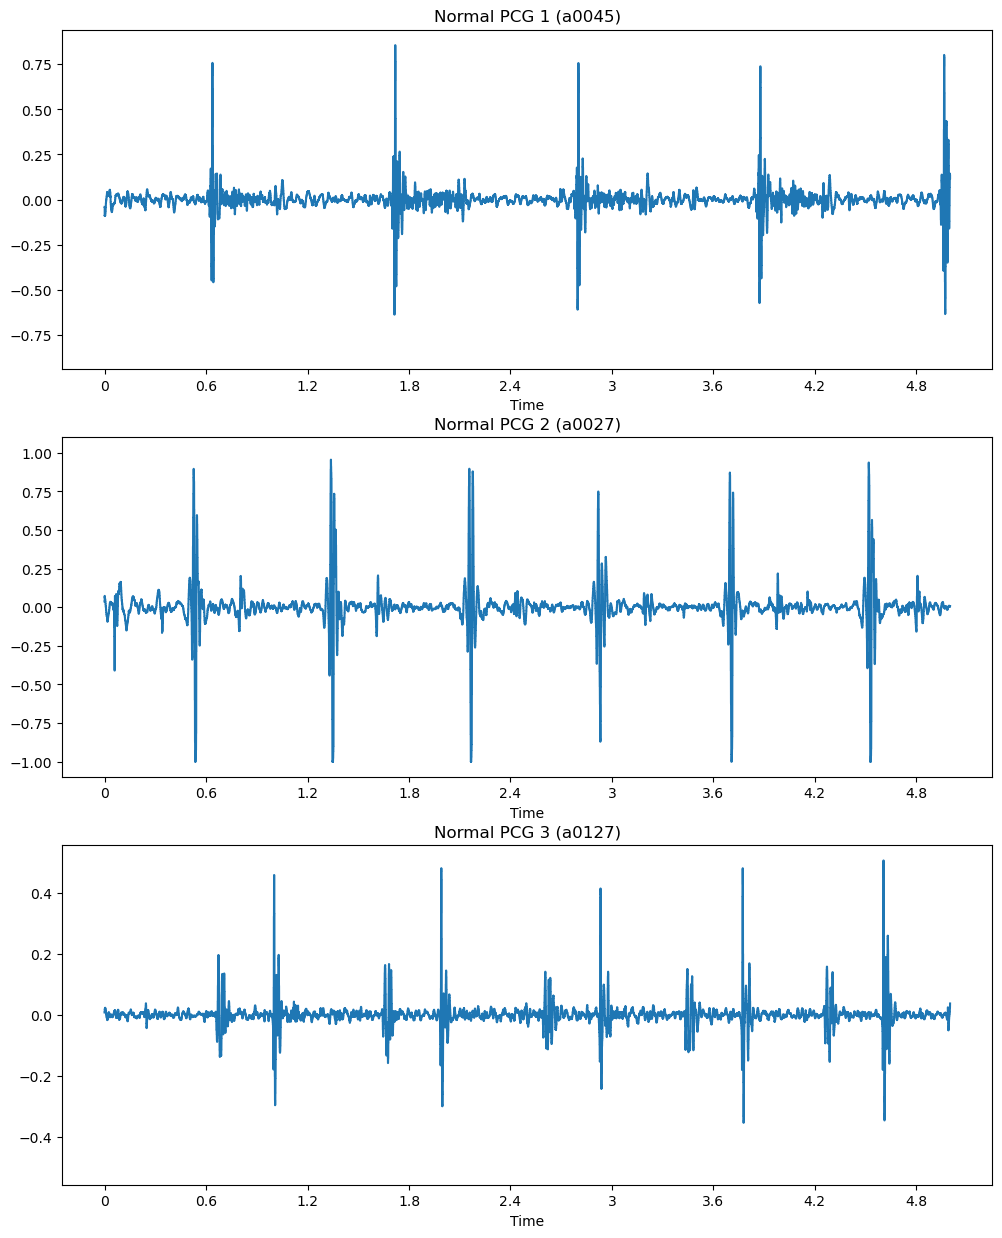

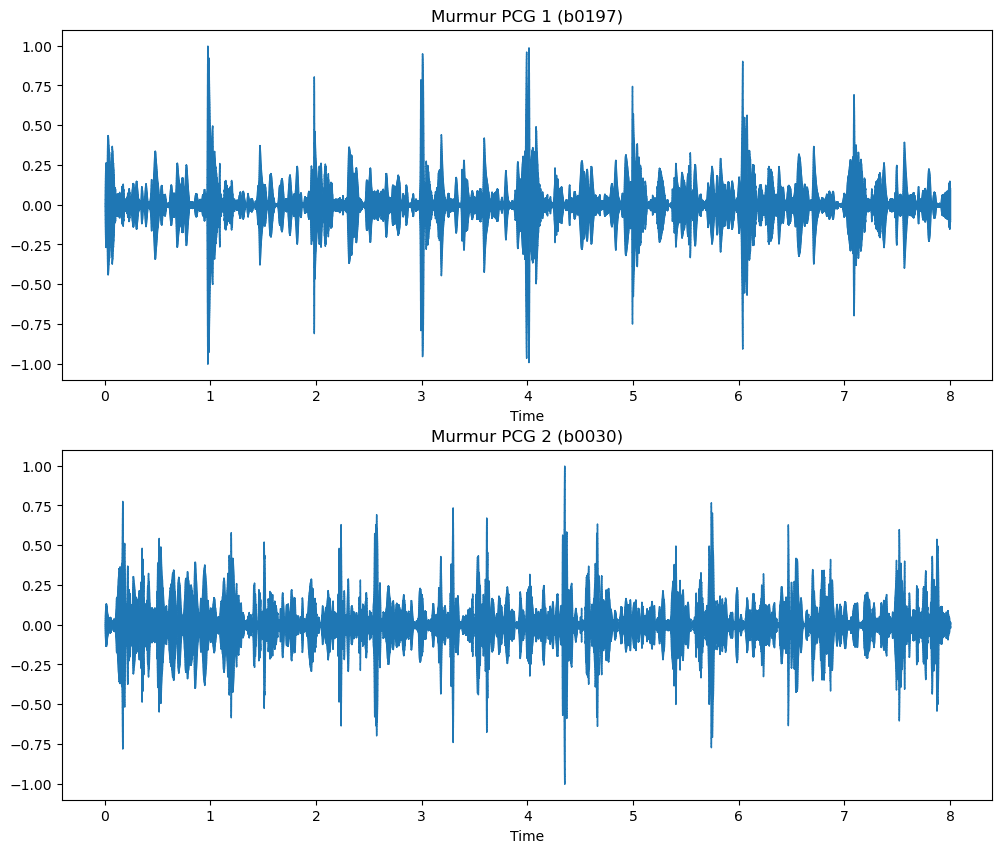

In [566]:
# plot them
# no need to plot 30 seconds worth to be honest. reduce to 5-10 seconds
secs = 5

fig, ax = plt.subplots(nrows=3, figsize=(12, 5*3))
librosa.display.waveshow(normal_rec_1[:secs*sr_physio16],sr=sr_physio16,ax=ax[0])
ax[0].set(title='Normal PCG 1 (a0045)')
librosa.display.waveshow(normal_rec_2[:secs*sr_physio16],sr=sr_physio16,ax=ax[1])
ax[1].set(title='Normal PCG 2 (a0027)')
librosa.display.waveshow(normal_rec_3[:secs*sr_physio16],sr=sr_physio16,ax=ax[2])
ax[2].set(title='Normal PCG 3 (a0127)')
# now the murmurs
fig, ax = plt.subplots(nrows=2, figsize=(12, 5*2))
librosa.display.waveshow(murmur_rec_1,sr=sr_physio16,ax=ax[0])
ax[0].set(title='Murmur PCG 1 (b0197)')
librosa.display.waveshow(murmur_rec_2,sr=sr_physio16,ax=ax[1])
ax[1].set(title='Murmur PCG 2 (b0030)')

### 8.d.2 - Qualitative Observations on OAHS dataset

In [567]:
joint_snr = 3
target_freq = sr_physio16 # 2khz btw

# arrays
regular_pcgs = [normal_rec_1, normal_rec_2, normal_rec_2, murmur_rec_1, murmur_rec_2]
noise_paths = get_n_random_noise_paths_han(5) # 5 real world hospital sounds

noisy_pcgs = []
for regular_pcg, noise in zip(regular_pcgs, noise_paths):
  noises, noise_sr = load_from_filepath(noise)
  # downsample to the same frequency
  noise = downsample(noise_raw, noise_sr, target_freq)
  # match lengths
  noise = match_signal_and_noise_lengths(regular_pcg, noise)
  
  composite = create_composite_at_snr(regular_pcg, noise, joint_snr) # combine the two
  composite = rescale_pcg(composite) # normalize to end
  
  # that's all
  noisy_pcgs.append(composite)

noisy_n1, noisy_n2, noisy_n3, noisy_m1, noisy_m2 = noisy_pcgs
# n1 = normal 1, m2 = murmur 2, etc

[Text(0.5, 1.0, 'Noisy n1 (a0045). SNR: 3dB')]

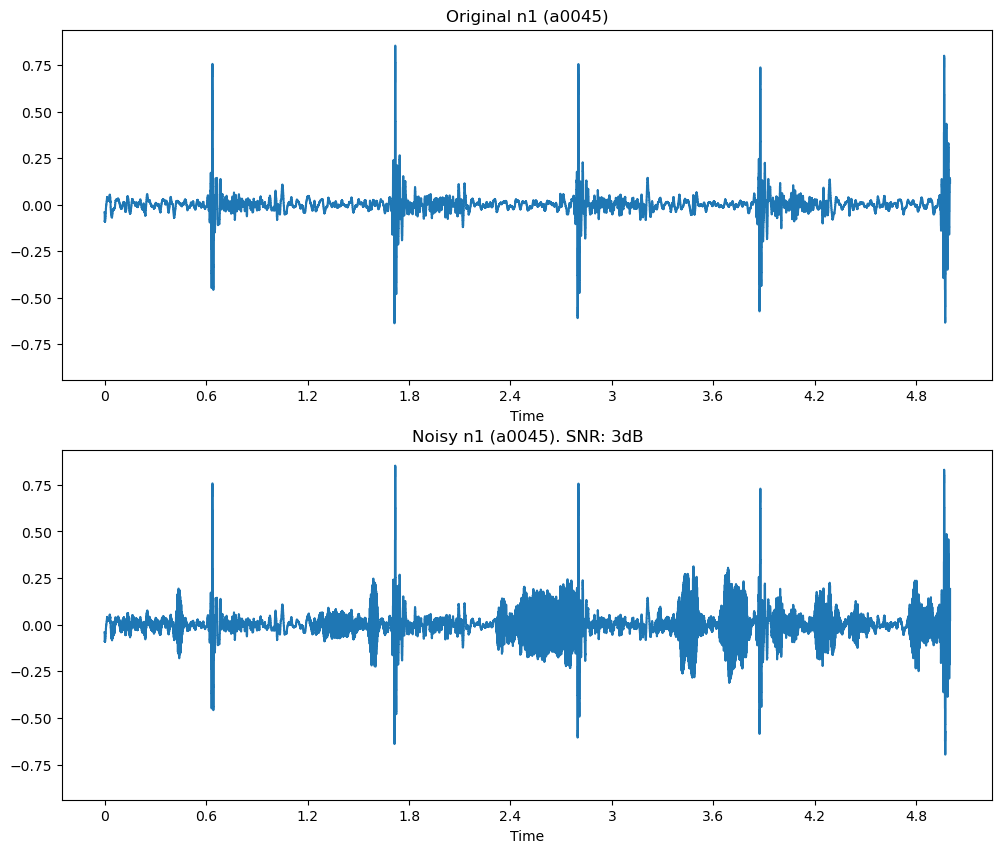

In [568]:
# compare them
secs = 5
# plotting 
fig, ax = plt.subplots(nrows=2, figsize=(12, 5*2))
librosa.display.waveshow(normal_rec_1[:secs*sr_physio16],sr=sr_physio16,ax=ax[0])
ax[0].set(title='Original n1 (a0045)')
librosa.display.waveshow(noisy_n1[:secs*sr_physio16],sr=sr_physio16,ax=ax[1])
ax[1].set(title=f'Noisy n1 (a0045). SNR: {joint_snr}dB')

In [569]:
# final steps: plot the model on these, then show results
model_denoised = []
segment_length = int(0.8 * sr_physio16) # seconds*sr (1600 samples here)
for noisy_rec in noisy_pcgs:
  cut_up_parts = []
  denoised_parts = []
  for i in range(0,len(noisy_rec)//segment_length):
      cut_up_parts.append(noisy_rec[i*segment_length:(i+1)*segment_length])
  with torch.no_grad():
    model.eval()
    for cut_up_part in cut_up_parts:
      cut_up_part = torch.tensor(cut_up_part, dtype=torch.float32)
      cut_up_part = cut_up_part.unsqueeze(0).unsqueeze(0).to(device) # expects (1,1,1600)
      denoised_part = model(cut_up_part)
      denoised_parts.append(denoised_part.cpu().detach().numpy()[0])
  model_denoised.append(np.concatenate(denoised_parts,axis=1)[0,:]) # remove the extra dimension
denoised_n1, denoised_n2, denoised_n3, denoised_m1, denoised_m2 = model_denoised

[Text(0.5, 1.0, 'Denoised n1 (a0045)')]

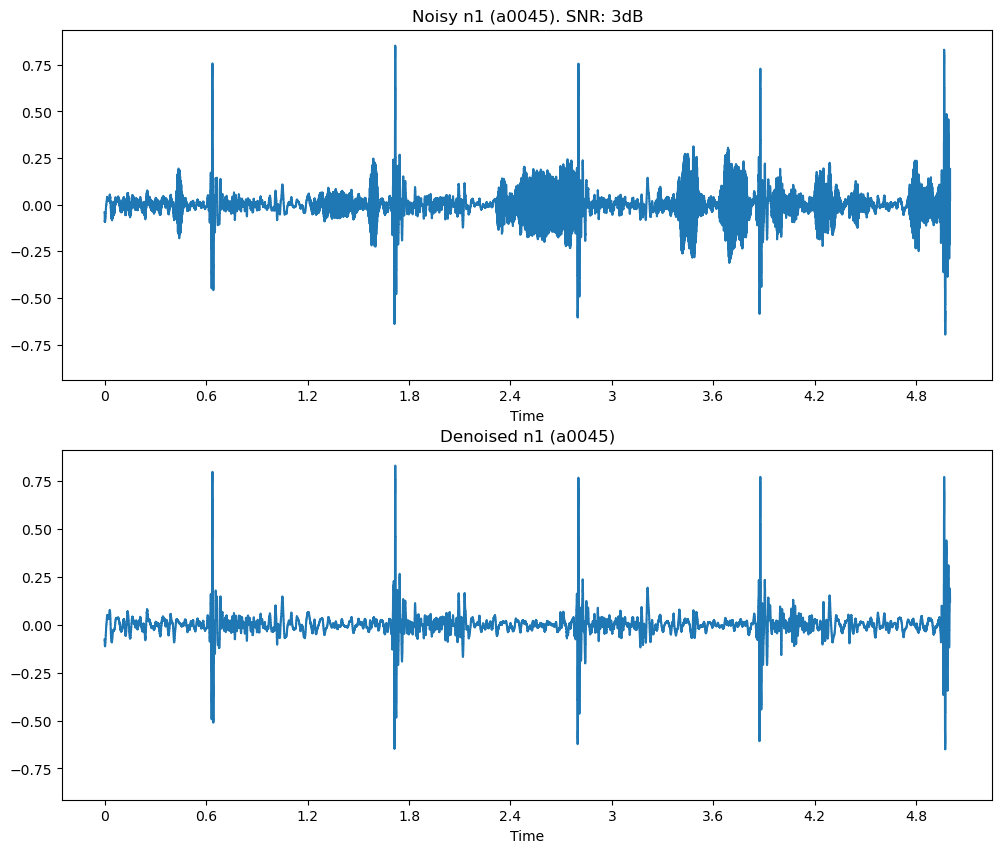

In [570]:
# ok, this is the final product basically
fig, ax = plt.subplots(nrows=2, figsize=(12, 5*2))
librosa.display.waveshow(noisy_n1[:secs*sr_physio16],sr=sr_physio16,ax=ax[0])
ax[0].set(title=f'Noisy n1 (a0045). SNR: {joint_snr}dB')

librosa.display.waveshow(denoised_n1[:secs*sr_physio16],sr=sr_physio16,ax=ax[1])
ax[1].set(title=f'Denoised n1 (a0045)')

# wow this actually looks great

[Text(0.5, 1.0, 'Denoised n1 (a0045)')]

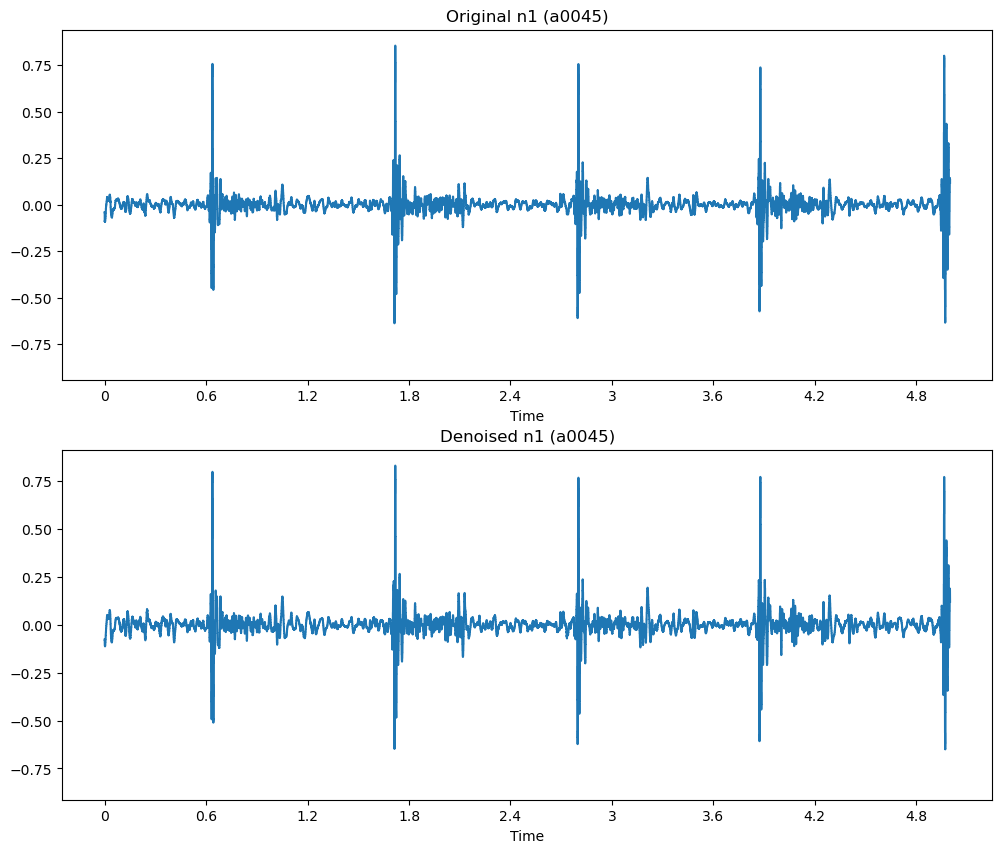

In [571]:
# compare orig with denoised
fig, ax = plt.subplots(nrows=2, figsize=(12, 5*2))
librosa.display.waveshow(normal_rec_1[:secs*sr_physio16],sr=sr_physio16,ax=ax[0])
ax[0].set(title=f'Original n1 (a0045)')

librosa.display.waveshow(denoised_n1[:secs*sr_physio16],sr=sr_physio16,ax=ax[1])
ax[1].set(title=f'Denoised n1 (a0045)')

# wow this actually looks great

[Text(0.5, 1.0, 'Noisy m1 (b0197). SNR: 3dB')]

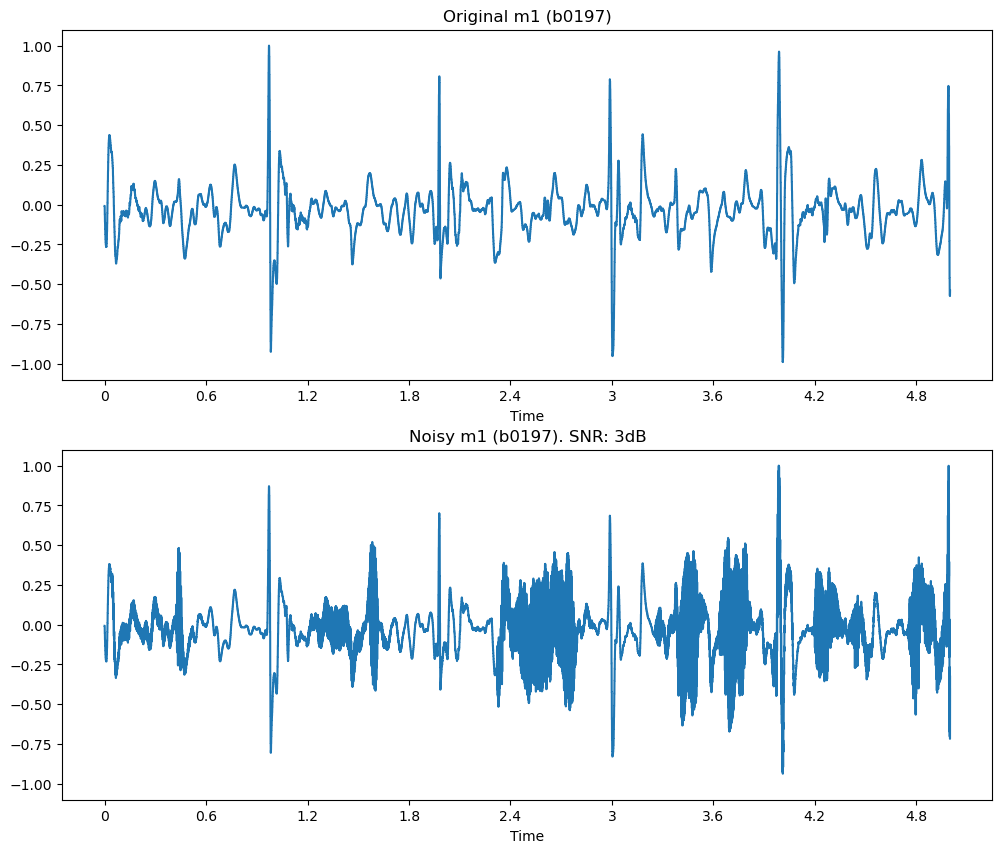

In [579]:
# for murmurs
fig, ax = plt.subplots(nrows=2, figsize=(12, 5*2))
librosa.display.waveshow(murmur_rec_1[:secs*sr_physio16],sr=sr_physio16,ax=ax[0])
ax[0].set(title=f'Original m1 (b0197)')

librosa.display.waveshow(noisy_m1[:secs*sr_physio16],sr=sr_physio16,ax=ax[1])
ax[1].set(title=f'Noisy m1 (b0197). SNR: {joint_snr}dB')

[Text(0.5, 1.0, 'Denoised m2 (b0197)')]

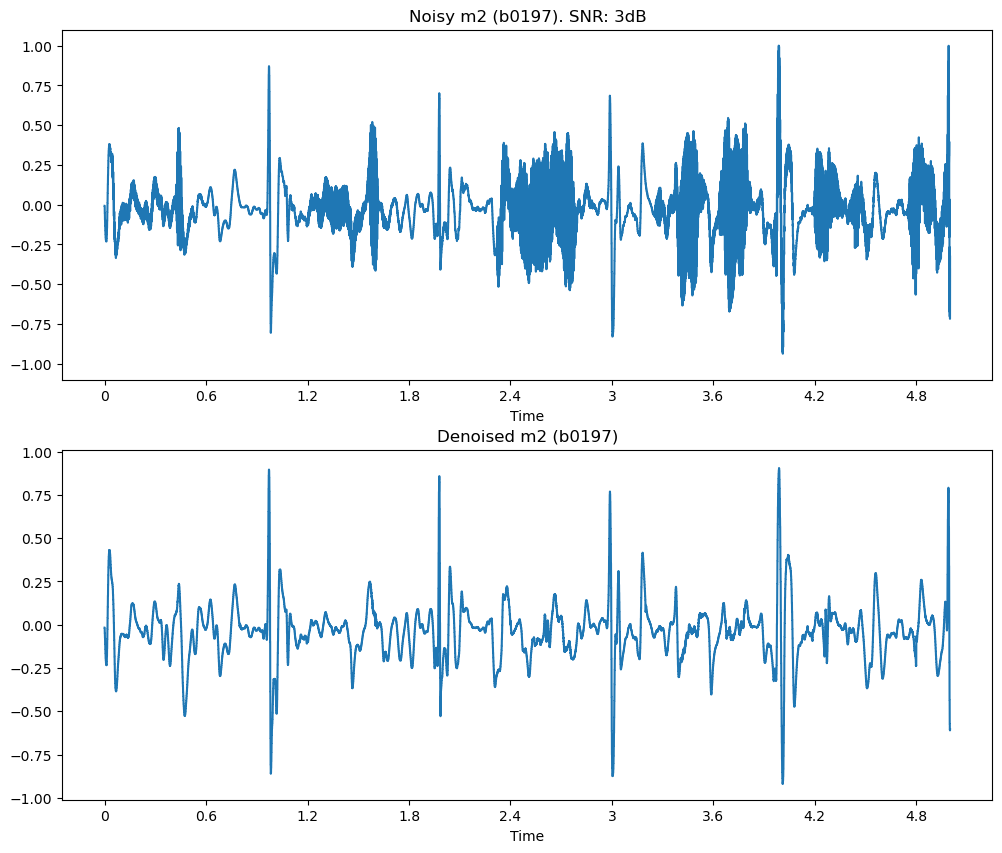

In [581]:
# for murmur, noisy vs denoised
fig, ax = plt.subplots(nrows=2, figsize=(12, 5*2))
librosa.display.waveshow(noisy_m1[:secs*sr_physio16],sr=sr_physio16,ax=ax[0])
ax[0].set(title=f'Noisy m2 (b0197). SNR: {joint_snr}dB')

librosa.display.waveshow(denoised_m1[:secs*sr_physio16],sr=sr_physio16,ax=ax[1])
ax[1].set(title=f'Denoised m2 (b0197)')

[Text(0.5, 1.0, 'Denoised m1 (b0197)')]

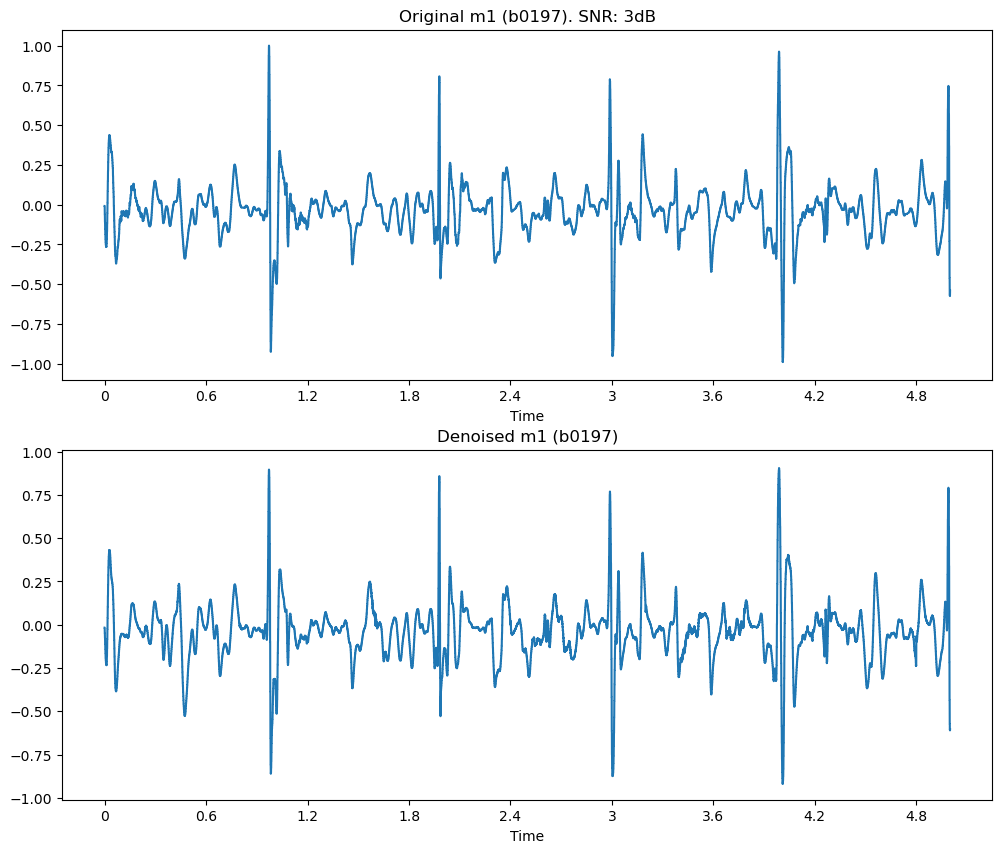

In [582]:
# for murmur, original vs denoised
fig, ax = plt.subplots(nrows=2, figsize=(12, 5*2))
librosa.display.waveshow(murmur_rec_1[:secs*sr_physio16],sr=sr_physio16,ax=ax[0])
ax[0].set(title=f'Original m1 (b0197). SNR: {joint_snr}dB')


librosa.display.waveshow(denoised_m1[:secs*sr_physio16],sr=sr_physio16,ax=ax[1])
ax[1].set(title=f'Denoised m1 (b0197)')

## 9. Appendix

In [576]:
# amount of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {total_params}")

Model parameters: 8049953
